
### Regression and Classification with the Ames Housing Data

---

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1127]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.linear_model import SGDRegressor, SGDClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
sns.set_style('whitegrid')
from IPython.display import display

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


## 1. Estimating the value of homes from fixed characteristics.

---

1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.


Build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

---


#### Fixed features to predict the price

<li> LotArea: Lot size in square feet
<li> Street: Type of road access to property
<li> BldgType: Type of dwelling
<li> Neighborhood: Physical locations within Ames city limits
<li> YearBuilt: Original construction date
<li> YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
<li> TotalBsmtSF: Total square feet of basement area
<li> 2ndFlrSF: Second floor square feet
<li> GrLivArea: Above grade (ground) living area square feet
<li> BsmtFullBath: Basement full bathrooms
<li> FullBath: Full bathrooms above grade
<li> TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
<li> Fireplaces: Number of fireplaces
<li> GarageYrBlt: Year garage was built
<li> GarageCars: Size of garage in car capacity
<li> WoodDeckSF: Wood deck area in square feet
<li> OpenPorchSF: Open porch area in square feet
<li> PoolArea: Pool area in square feet
<li> YrSold: Year Sold (YYYY)
<li> SaleType: Type of sale
<li> SaleCondition: Condition of sale


In [1885]:
# Load the data
house = pd.read_csv('./housing.csv')

In [1886]:
# Show first five rows
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [1887]:
house.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [1888]:
# Drop Id column
house.drop("Id", axis = 1, inplace = True)

#### Overview
Dataset includes **80** variables focus on the quality and quantity of many physical attributes of the property. Most
of the variables are exactly the type of information that a typical home buyer would want to
know about a potential property.

<li> In general the **20** continuous variables relate to various area dimensions for each observation. In
addition to the typical lot size and total dwelling square footage found on most common home
listings, other more specific variables are quantified in the data set. 
<li> The **14** discrete variables typically quantify the number of items occurring within the house.
Most are specifically focused on the number of kitchens, bedrooms, and bathrooms (full and
half) located in the basement and above grade (ground) living areas of the home.
<li> There are a large number of categorical variables: **23 nominal, 23 ordinal**. They range from 2 to 28 classes with the smallest being STREET (gravel or paved) and
the largest being NEIGHBORHOOD (areas within the Ames city limits). The nominal variables
typically identify various types of dwellings, garages, materials, and environmental conditions
while the ordinal variables typically rate various items within the property. 

In [1889]:
# check the dimensionality of the DataFrame
house.shape

(1460, 80)

In [1890]:
# look for a summary of a DataFrame
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

#### Filtering the data

In [1891]:
# check unique values in 'mszoning' column
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [1892]:
# remove any houses that are not residential from the dataset
house = house[house.MSZoning != 'C (all)']

In [1893]:
# check the output
house.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [1894]:
# check the dimensionality of the DataFrame
house.shape

(1450, 80)

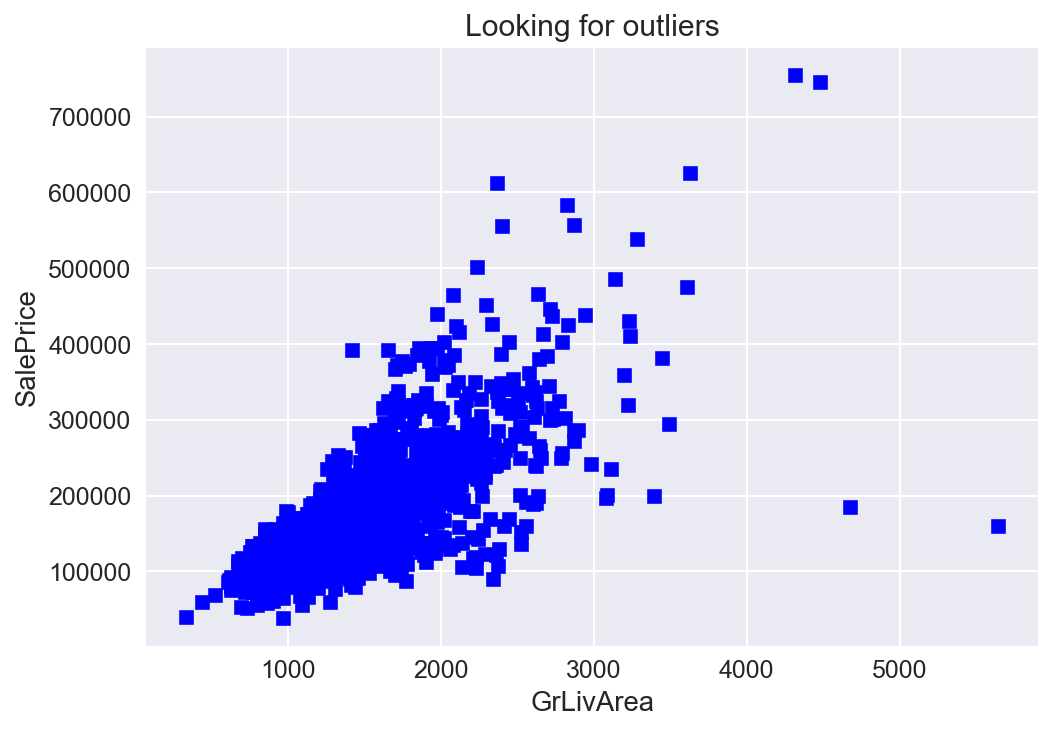

In [1895]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(house.GrLivArea, house.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [1896]:
# eliminate outliers
house = house[house.GrLivArea < 4000]

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [1897]:
# check the dimensionality of the DataFrame
house.shape

(1446, 80)

#### Check missing values

In [1898]:
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1441  0.996542
MiscFeature    1394  0.964039
Alley          1357  0.938451
Fence          1169  0.808437
FireplaceQu     681  0.470954
LotFrontage     259  0.179115
GarageType       79  0.054633
GarageCond       79  0.054633
GarageFinish     79  0.054633
GarageQual       79  0.054633
GarageYrBlt      79  0.054633
BsmtFinType2     38  0.026279
BsmtExposure     38  0.026279
BsmtQual         37  0.025588
BsmtCond         37  0.025588
BsmtFinType1     37  0.025588
MasVnrArea        8  0.005533
MasVnrType        8  0.005533
Electrical        1  0.000692
RoofMatl          0  0.000000

I'll consider that when more than 15% of the data is missing, I should delete the corresponding variable. This means that I will not try any trick to fill the missing data in these cases. 

Finally, I have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In [1899]:
#dealing with missing data
house = house.drop((missing_data[missing_data['Total'] > 1]).index,1)
house = house.drop(house.loc[house['Electrical'].isnull()].index)


In [1900]:
# check the dimensionality of the DataFrame
house.shape

(1445, 62)

#### Correlation matrix (heatmap style)


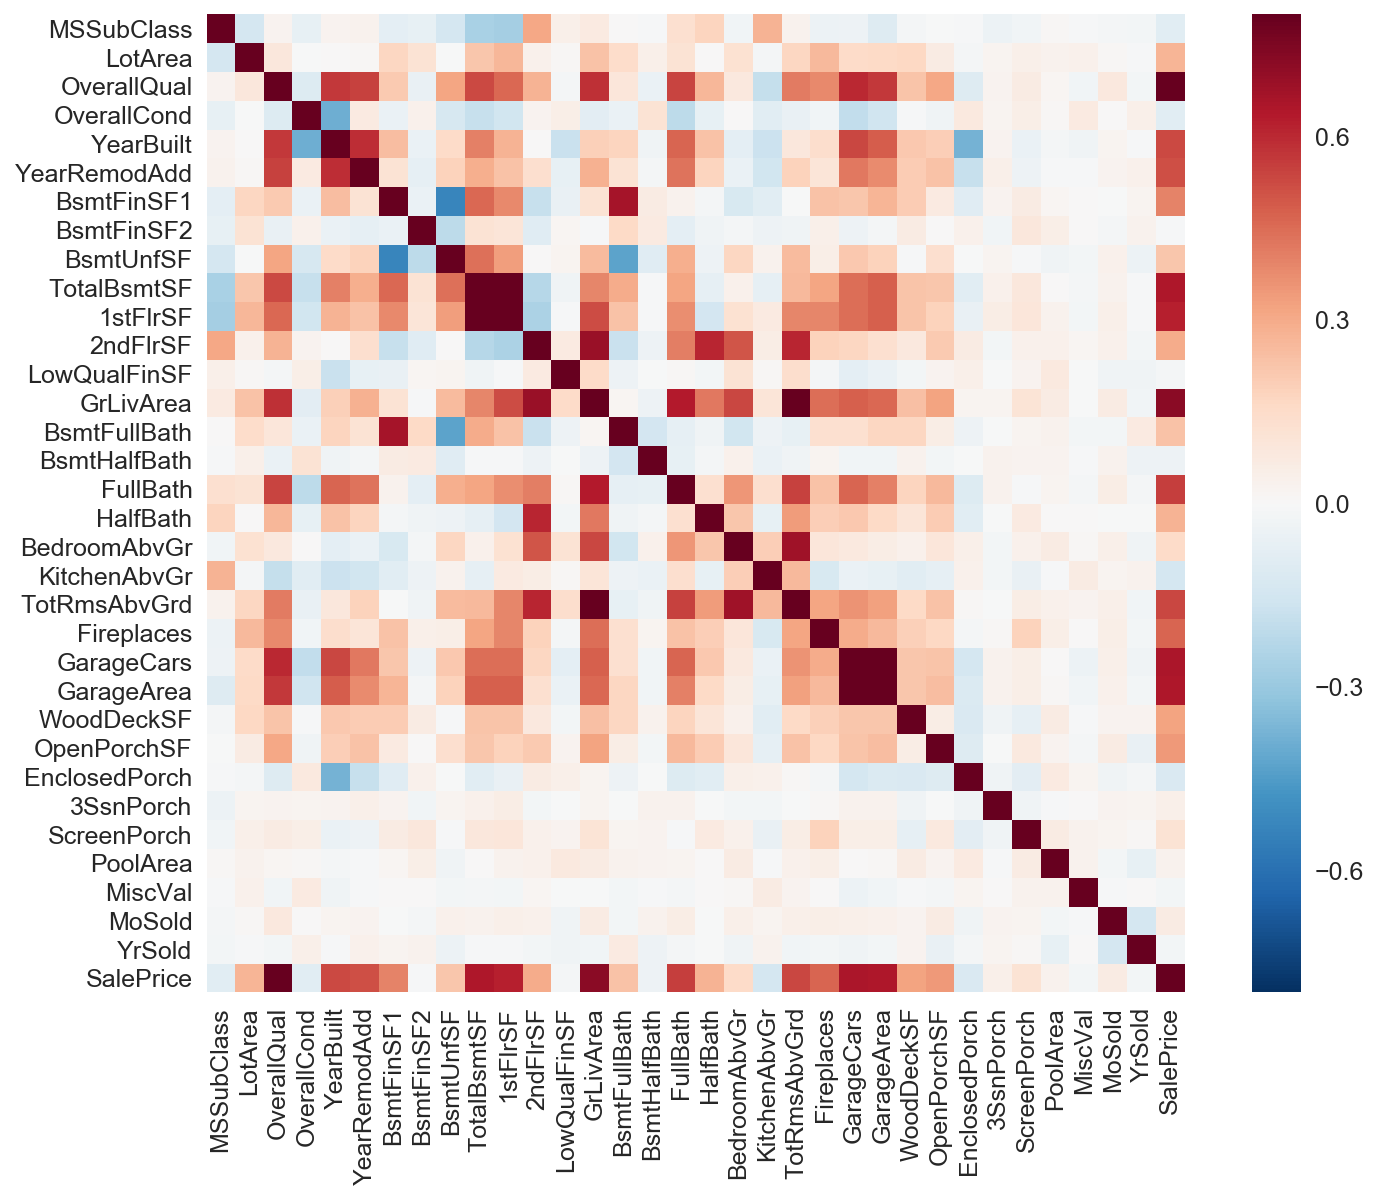

In [1901]:
#correlation matrix
corr_mat = house.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

There are two red colored squares that get my attention. The first one refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'GarageX' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity.

Another thing that got my attention was the 'SalePrice' correlations. We can see 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' have very strong correlation, but we can also see many other variables that should be taken into account.

#### 'SalePrice' correlation matrix (zoomed heatmap style)


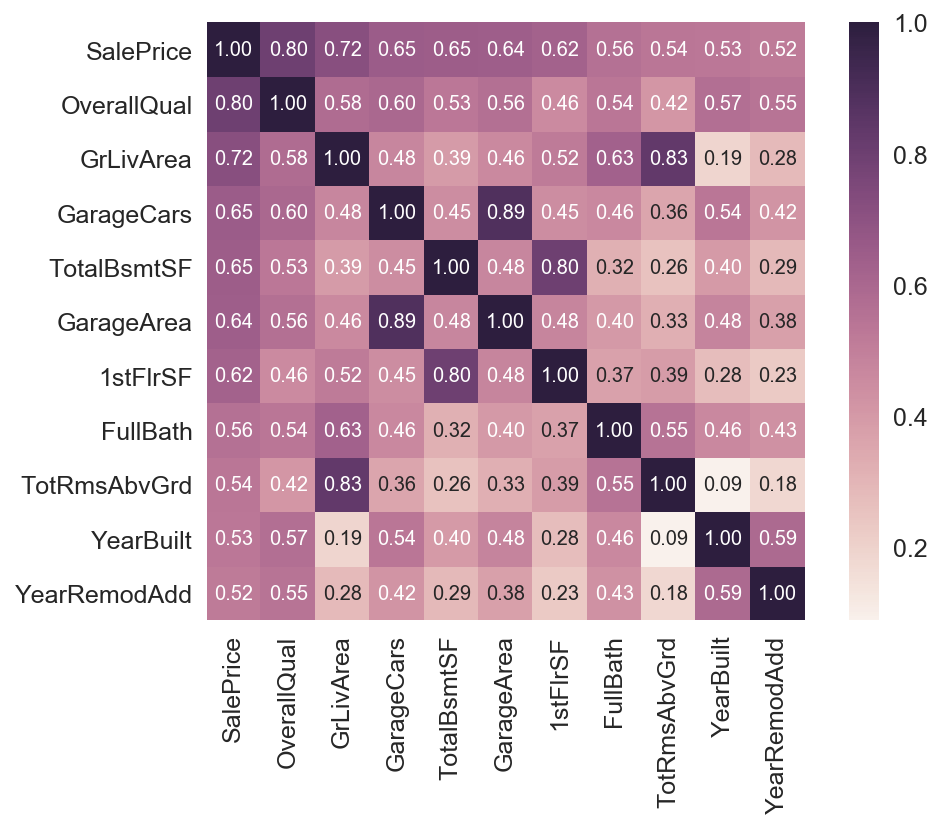

In [1902]:
#saleprice correlation matrix
k = 11 #number of variables for heatmap
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, \
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

These are the variables most correlated with 'SalePrice'. My thoughts on this:
'OverallQual'(will not be used because is not fixed feature), 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.

'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. But, we just need one of these variables in our analysis to prevent multicollinearity (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).

'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF'.

'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. 

#### Choosing fixed features

In [1903]:
fixed_features_price = ['LotArea', 'Street', 'Neighborhood', 'BldgType', 'YearRemodAdd', 'TotalBsmtSF',\
                       'GrLivArea', 'BsmtFullBath', 'FullBath', 'Fireplaces', 'GarageCars', 'WoodDeckSF',\
                       'OpenPorchSF', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']
fixed_features_price

['LotArea',
 'Street',
 'Neighborhood',
 'BldgType',
 'YearRemodAdd',
 'TotalBsmtSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'SalePrice']

In [1904]:
house_fixed_price = house[fixed_features_price]

In [1905]:
house_fixed_price.head()

LotArea Street Neighborhood BldgType  YearRemodAdd  TotalBsmtSF  GrLivArea  \
0     8450   Pave      CollgCr     1Fam          2003          856       1710   
1     9600   Pave      Veenker     1Fam          1976         1262       1262   
2    11250   Pave      CollgCr     1Fam          2002          920       1786   
3     9550   Pave      Crawfor     1Fam          1970          756       1717   
4    14260   Pave      NoRidge     1Fam          2000         1145       2198   

   BsmtFullBath  FullBath  Fireplaces  GarageCars  WoodDeckSF  OpenPorchSF  \
0             1         2           0           2           0           61   
1             0         2           1           2         298            0   
2             1         2           1           2           0           42   
3             1         1           1           3           0           35   
4             1         2           1           3         192           84   

   YrSold SaleType SaleCondition  SalePrice  
0    2008       WD        Normal     208500  
1    2007       WD        Normal     181500  
2    2008       WD        Normal     223500  
3    2006       WD       Abnorml     140000  
4    2008       WD        Normal     250000

#### Log transformation "SalePrice" variable
The point here is to test 'SalePrice'. We'll do this paying attention to:
<li> Histogram - Kurtosis and skewness.
<li> Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

In [1906]:
# print "Skewness: {}".format(house_fixed_price['SalePrice'].skew())
# print "Kurtosis: {}".format(house_fixed_price['SalePrice'].kurt())

In [1907]:
#histogram and normal probability plot
# sns.distplot(house_fixed_price['SalePrice'], fit=norm);
# fig = plt.figure()
# res = stats.probplot(house_fixed_price['SalePrice'], plot=plt)

<li> Deviate from the normal distribution.
<li> Have appreciable positive skewness.
<li> Show peakedness.

In [1908]:
# Transoformation
# house_fixed_price.SalePrice = np.log1p(house_fixed_price.SalePrice)

In [1909]:
# check the output
# sns.distplot(house_fixed_price['SalePrice'], fit=norm);
# fig = plt.figure()
# res = stats.probplot(house_fixed_price['SalePrice'], plot=plt)

#### Log Transformation Skewed numeric features:


In [1910]:
# numeric_feats = house_fixed_price.dtypes[house_fixed_price.dtypes != "object"].index
# numeric_feats = numeric_feats[:-1]
# numeric_feats

In [1911]:
# skewed_feats = house_fixed_price[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
# skewed_feats = skewed_feats[skewed_feats > 0.5]
# skewed_feats = skewed_feats.index
# skewed_feats

In [1912]:
# house_fixed_price[skewed_feats] = np.log1p(house_fixed_price[skewed_feats])

In [1913]:
# house_fixed_price.shape

#### Transform categorical variable into binary

In [1914]:
categoric_feats = house_fixed_price.dtypes[house_fixed_price.dtypes == "object"].index
categoric_feats.values

array(['Street', 'Neighborhood', 'BldgType', 'SaleType', 'SaleCondition'], dtype=object)

In [1915]:
dummies = pd.get_dummies(house_fixed_price[categoric_feats], drop_first=True)
dummies.shape

(1445, 42)

In [1916]:
house_fixed_dum = pd.concat([dummies, house_fixed_price], axis=1)
house_fixed_dum.drop(categoric_feats,axis=1, inplace=True)

In [1917]:
house_fixed_dum.columns

Index([u'Street_Pave', u'Neighborhood_Blueste', u'Neighborhood_BrDale',
       u'Neighborhood_BrkSide', u'Neighborhood_ClearCr',
       u'Neighborhood_CollgCr', u'Neighborhood_Crawfor',
       u'Neighborhood_Edwards', u'Neighborhood_Gilbert',
       u'Neighborhood_IDOTRR', u'Neighborhood_MeadowV',
       u'Neighborhood_Mitchel', u'Neighborhood_NAmes', u'Neighborhood_NPkVill',
       u'Neighborhood_NWAmes', u'Neighborhood_NoRidge',
       u'Neighborhood_NridgHt', u'Neighborhood_OldTown', u'Neighborhood_SWISU',
       u'Neighborhood_Sawyer', u'Neighborhood_SawyerW',
       u'Neighborhood_Somerst', u'Neighborhood_StoneBr',
       u'Neighborhood_Timber', u'Neighborhood_Veenker', u'BldgType_2fmCon',
       u'BldgType_Duplex', u'BldgType_Twnhs', u'BldgType_TwnhsE',
       u'SaleType_CWD', u'SaleType_Con', u'SaleType_ConLD', u'SaleType_ConLI',
       u'SaleType_ConLw', u'SaleType_New', u'SaleType_Oth', u'SaleType_WD',
       u'SaleCondition_AdjLand', u'SaleCondition_Alloca',
       u'SaleCond

#### Train/Validation/Test split

In [1918]:
house_fixed_dum.YrSold.value_counts()

2009    336
2007    325
2006    312
2008    300
2010    172
Name: YrSold, dtype: int64

In [1919]:
# Create 2006 - 2009 dataframe to fit the final model
data_pre2010 = house_fixed_dum[house_fixed_dum.YrSold != 2010]
# Create 2010 dataframe to test the final model
data_2010 = house_fixed_dum[house_fixed_dum.YrSold == 2010]
# Create 2006 - 2008 dataframe to fit different models
data_pre2009 = data_pre2010[data_pre2010.YrSold != 2009]
# Create 2009 dataframe to choose the final model
data_2009 = house_fixed_dum[house_fixed_dum.YrSold == 2009]

#### Modeling

In [1920]:
features = [feature for feature in data_pre2009.columns \
            if feature not in ['YearRemodAdd','YrSold', 'SalePrice']]
print features

['Street_Pave', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'Fireplaces', 'Garag

In [1921]:
numeric = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',\
           'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF']

In [1922]:
X_train = data_pre2009[features]
y_train = data_pre2009.SalePrice.values

X_test = data_2009[features]
y_test = data_2009.SalePrice.values

In [1923]:
X = house_fixed_dum[features]
y = house_fixed_dum.SalePrice.values

In [1924]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

In [1925]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(937, 51)
(937,)
(336, 51)
(336,)


#### Linear Regression without regularization

In [1926]:
linreg = LinearRegression()

model = linreg.fit(Xs_train, y_train)

# Linear Regression with plot of predicted vs. actual y
y_pred_train = model.predict(Xs_train)
y_pred_test = model.predict(Xs_test)
linreg_score = model.score(Xs_test, y_test)
linreg_coef = model.coef_
linreg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print "score:", linreg_score
# Calculate the MSE of model using sklearn.metrics.mean_squared_error.
print "RMSE:", linreg_rmse
print "Model Coefficients:", linreg_coef


score: 0.836258705222
RMSE: 32552.8028397
Model Coefficients: [  2283.1659151    -986.737516    -2134.15614877  -5686.23510546
  -3824.90951263  -2671.33316274   -731.76981515  -7937.79740621
  -4132.22286212  -5234.08735663  -3371.74487618  -5509.48584424
 -10579.33589518   -864.62843742  -5485.8663696    4580.50792139
   9917.89156061 -11209.11736066  -5854.98219903  -7360.37549332
  -3574.41622553   1867.55848607   6763.61594469  -1016.40483312
    830.36638994  -3341.45233459  -5018.55927519  -2439.52015906
  -4268.55132056   1870.59158057   2199.19527669    465.53918509
  -1056.97310337     51.12735002   3489.86161687   1104.12013018
   1766.41160285   1876.11253473    287.35986048    106.98750023
   3885.10396178   9497.25724432   4195.59667302  11981.91853125
  29953.85311743   7851.19528815   -149.45488513   4849.72750409
   9211.16242596   3320.94143942   3618.46129831]


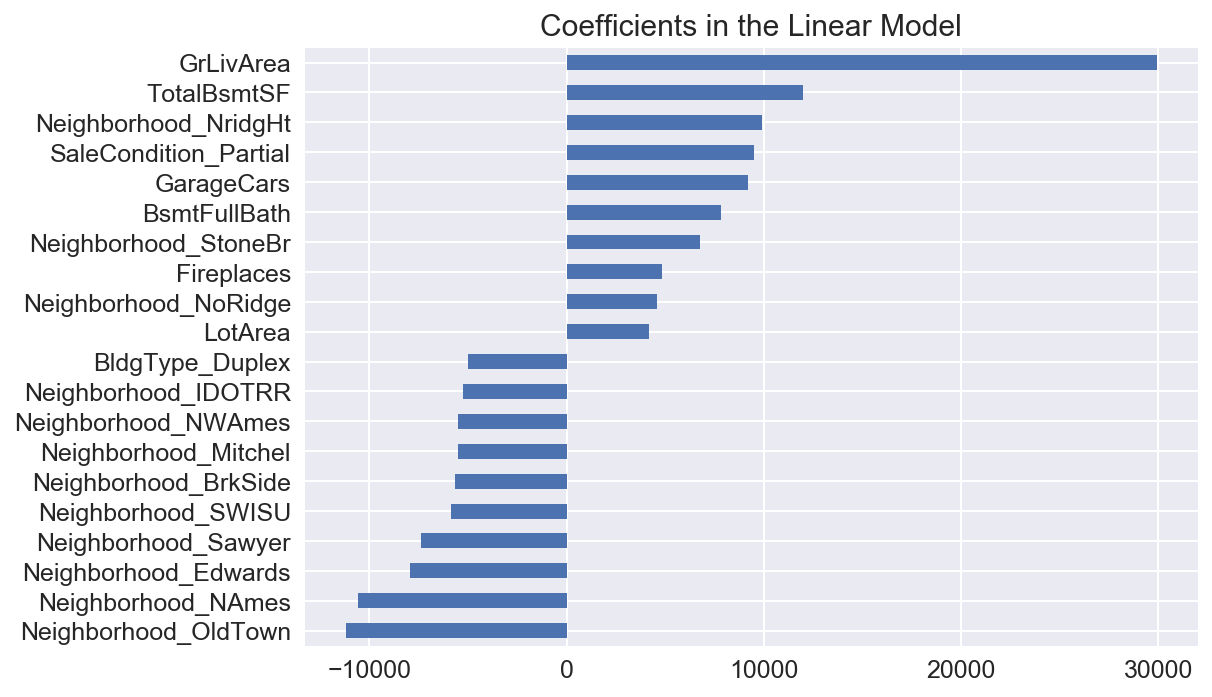

In [1927]:
# Plot important coefficients
coefs = pd.Series(linreg_coef, index = X_train.columns)

imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()

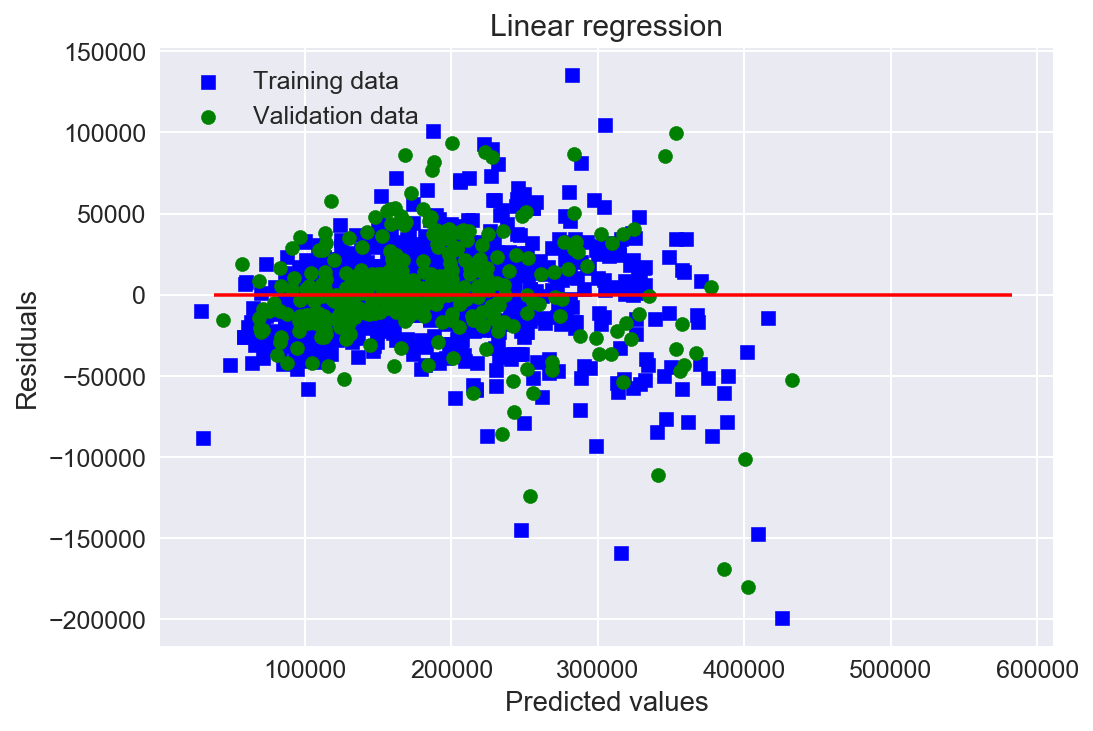

In [1928]:
# Plot residuals

plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

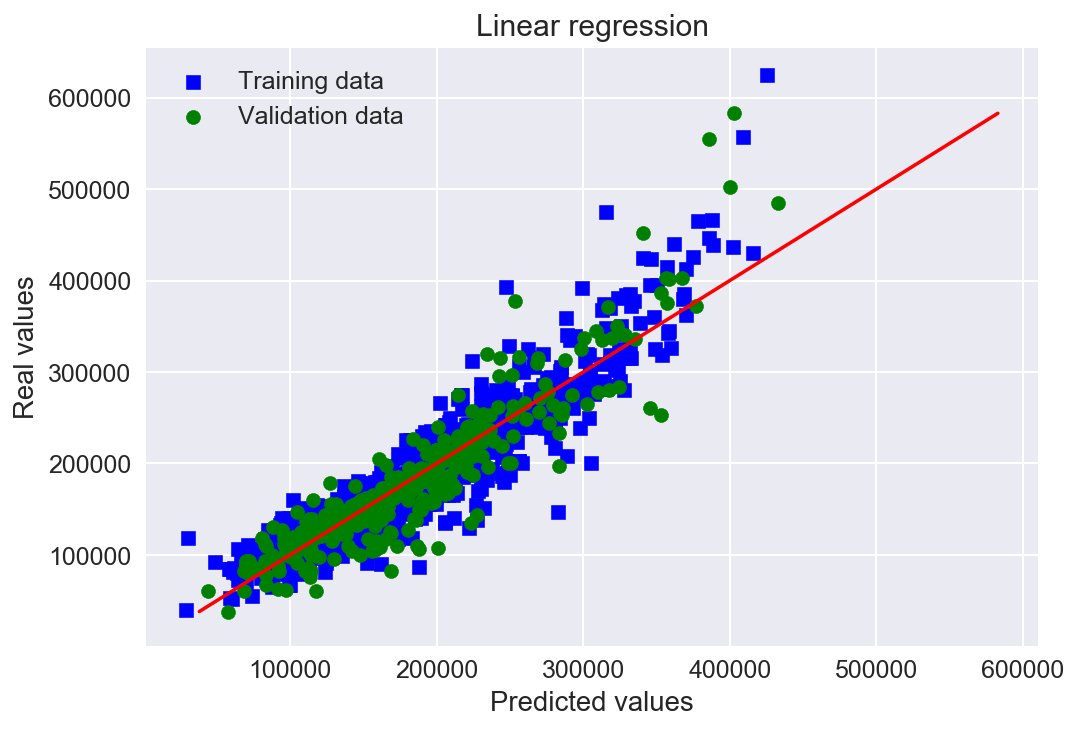

In [1929]:
# Plot predictions
plt.scatter(y_pred_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Linear Regression with Ridge regularization (L2 penalty)

In [1930]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(Xs_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 3)
ridge.fit(Xs_train, y_train)
r_alpha = ridge.alpha_
print("Best alpha :", r_alpha)

('Best alpha :', 60.0)
Try again for more precision with alphas centered around 60.0
('Best alpha :', 69.0)


In [1931]:
y_pred_train = ridge.predict(Xs_train)
y_pred_test = ridge.predict(Xs_test)
ridge_score = ridge.score(Xs_test, y_test)
ridge_coef = ridge.coef_
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print "score:", ridge_score
print "RMSE:", ridge_rmse
print "Best Coefficients:\n", ridge_coef


score: 0.833024353683
RMSE: 32872.7354228
Best Coefficients:
[  2100.77237164   -725.94077192   -747.03751971  -2400.37377853
  -1482.15510815   1482.57845766   2439.04223927  -3835.4353105
  -1049.12126071  -2612.16309723  -2077.36693401  -2778.76422115
  -4722.9920388    -580.35077767  -2248.43398722   6969.22009093
  11925.37602938  -6388.0066855   -3362.41830778  -3656.24364726
   -887.24796961   4425.50137595   7854.06988937   1039.3589447
   2275.0504196   -3067.25398738  -4714.12800227  -2022.9594188
  -3297.97386773   1474.89652381   1983.03321884    157.71334263
  -1254.41189625    -96.11274956   5230.01892722    617.6500404
    201.09217691   1432.03083086    130.47577598   -281.05739235
   2706.23669379   5963.19278188   4019.93738641  12036.678249
  25777.28176513   7232.3634264    2624.97884152   5938.12193436
   9939.36500394   3819.99279395   3986.18192717]


Ridge picked 51 features and eliminated the other 0 features


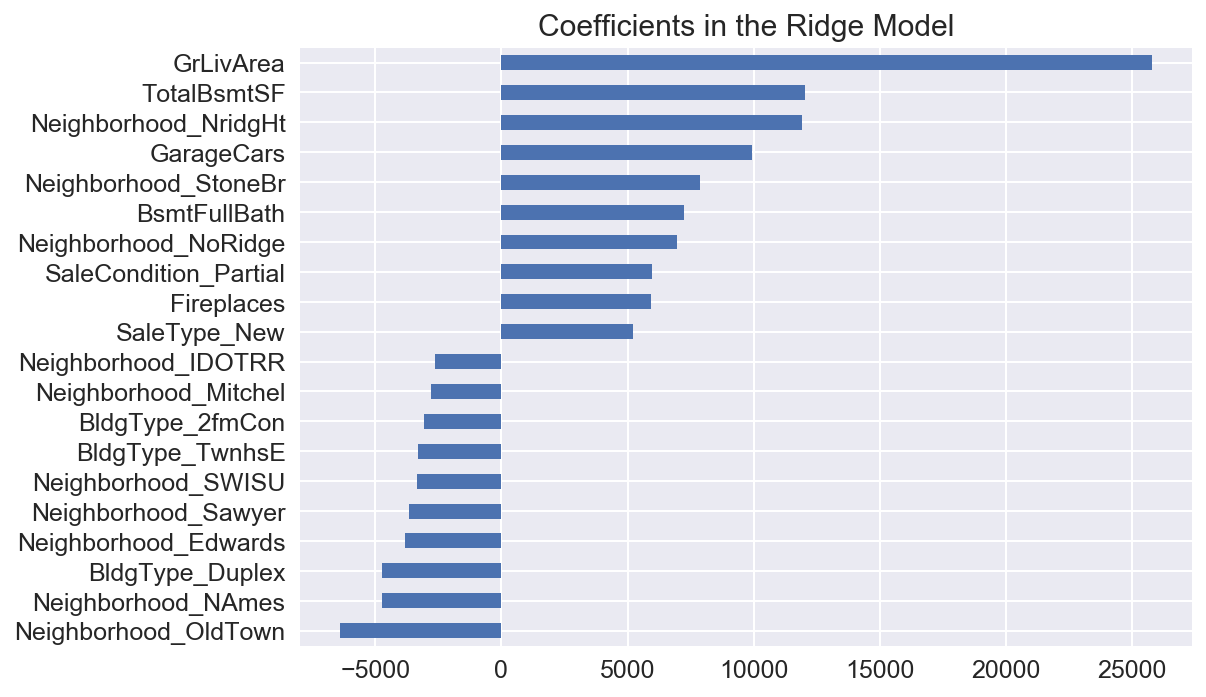

In [1932]:
# Plot important coefficients
coefs = pd.Series(ridge_coef, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

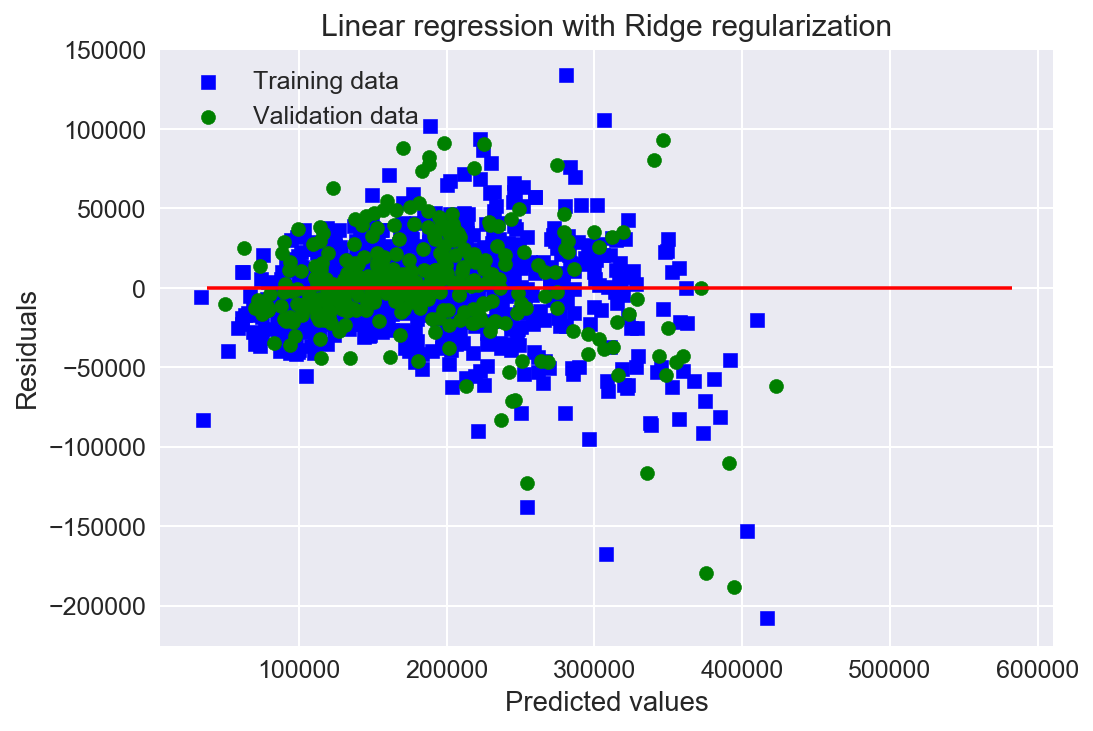

In [1933]:
# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

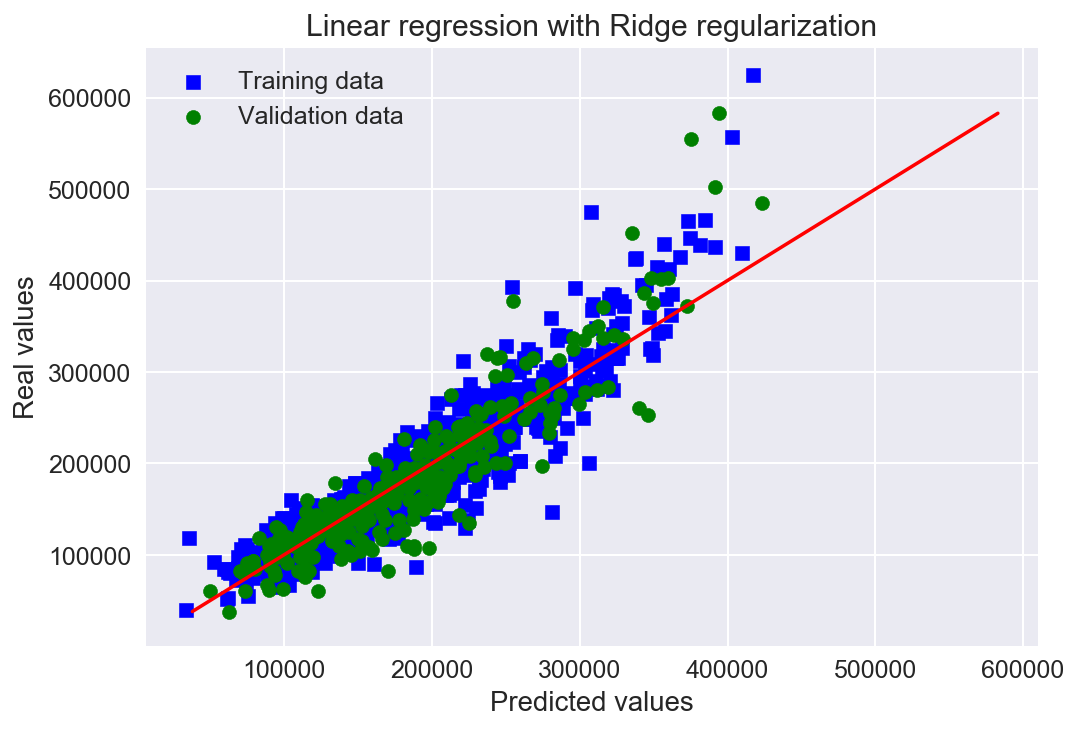

In [1934]:
# Plot predictions
plt.scatter(y_pred_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Linear Regression with Lasso regularization (L1 penalty)

In [1935]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 3)
lasso.fit(Xs_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

('Best alpha :', 1.0)


In [1936]:
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 3)
lasso.fit(Xs_train, y_train)
l_alpha = lasso.alpha_
print("Best alpha :", l_alpha)

Try again for more precision with alphas centered around 1.0
('Best alpha :', 1.3999999999999999)


In [1937]:

y_pred_train = lasso.predict(Xs_train)
y_pred_test = lasso.predict(Xs_test)
lasso_score = lasso.score(Xs_test, y_test)
lasso_coef = lasso.coef_
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print "score:", lasso_score
print "RMSE:", lasso_rmse
print "Best Coefficients:\n", lasso_coef

score: 0.836237506436
RMSE: 32554.9099978
Best Coefficients:
[  2279.1459254    -974.29128682  -2091.6139411   -5596.78156182
  -3759.59952912  -2542.78435574   -645.50562119  -7830.30611626
  -4034.17810781  -5165.79126879  -3333.91813918  -5429.89280936
 -10419.96604461   -845.16115493  -5394.30145638   4645.28951506
   9999.02484966 -11089.71969175  -5800.59551419  -7262.83325281
  -3497.56931298   1961.34854892   6808.60583846   -950.42086897
    874.05595999  -3338.53506117  -5018.09515631  -2432.6024852
  -4245.96347865   1865.50397363   2194.84494508    459.44526531
  -1058.20006862     47.99610078   3479.62868297   1099.96363157
   1751.73073686   1874.49077261    284.49172814    102.30952086
   3879.85129361   9498.69606511   4189.0776789   11987.8006288
  29949.65654779   7845.57035249   -140.65292399   4853.35598803
   9216.7796542    3324.12158508   3614.53361297]


Lasso picked 51 features and eliminated the other 0 features


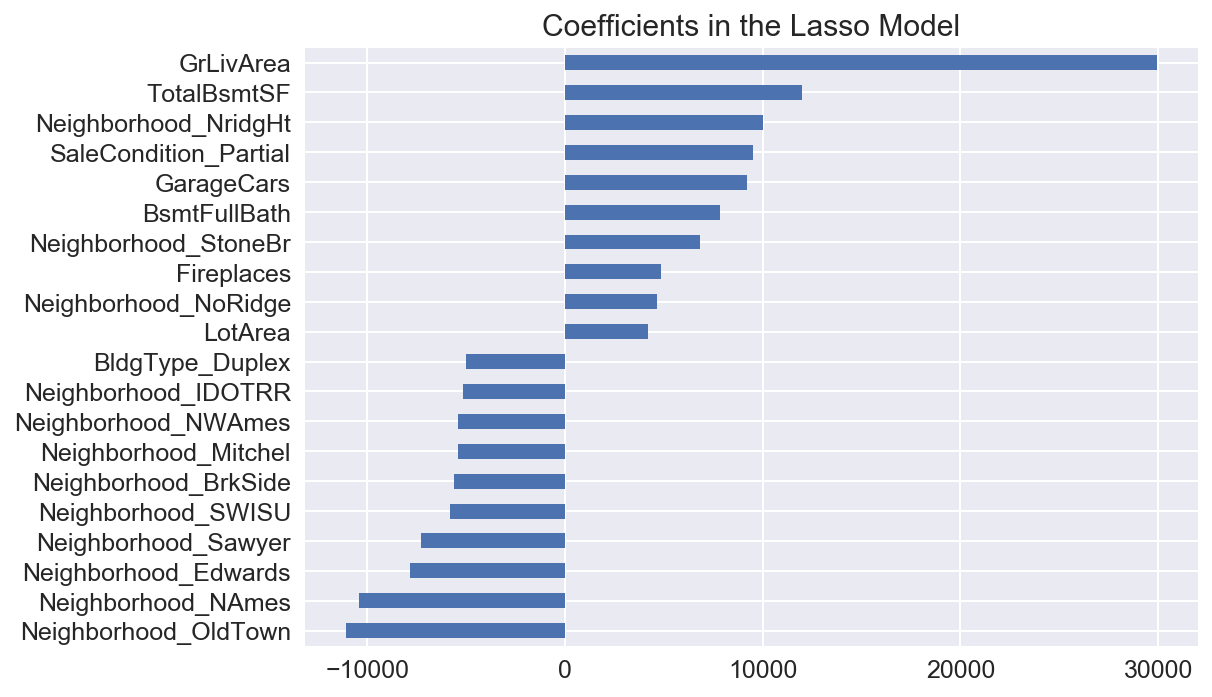

In [1938]:
# Plot important coefficients
coefs = pd.Series(lasso_coef, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

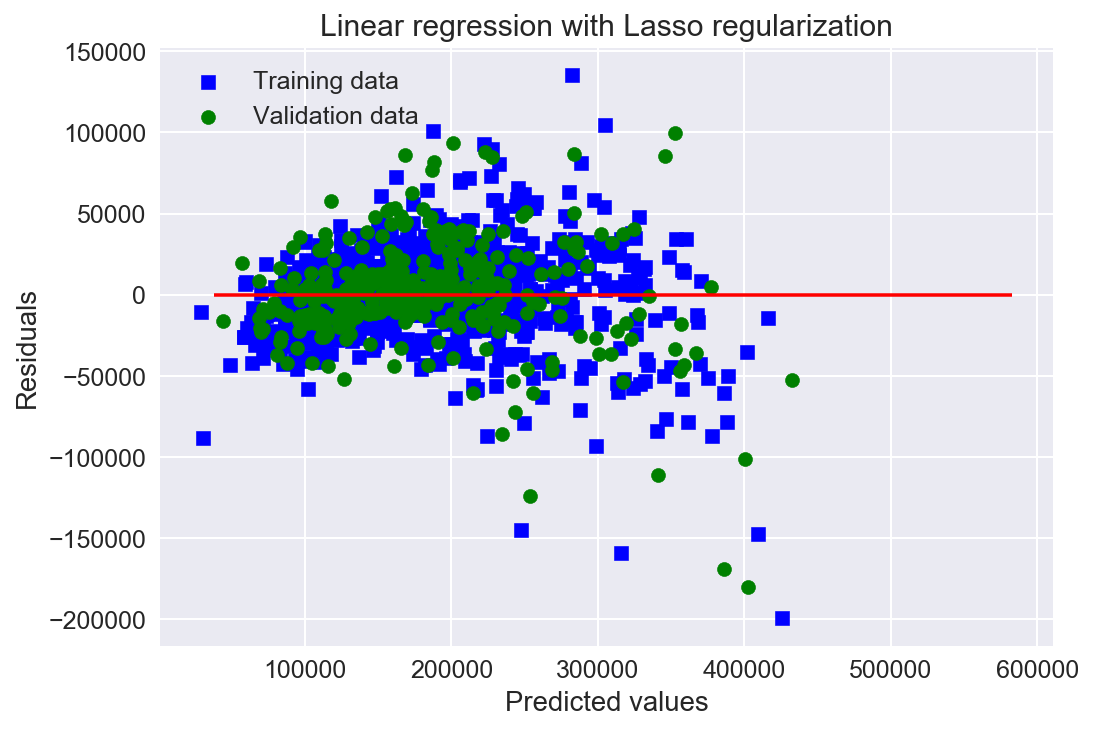

In [1939]:
# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

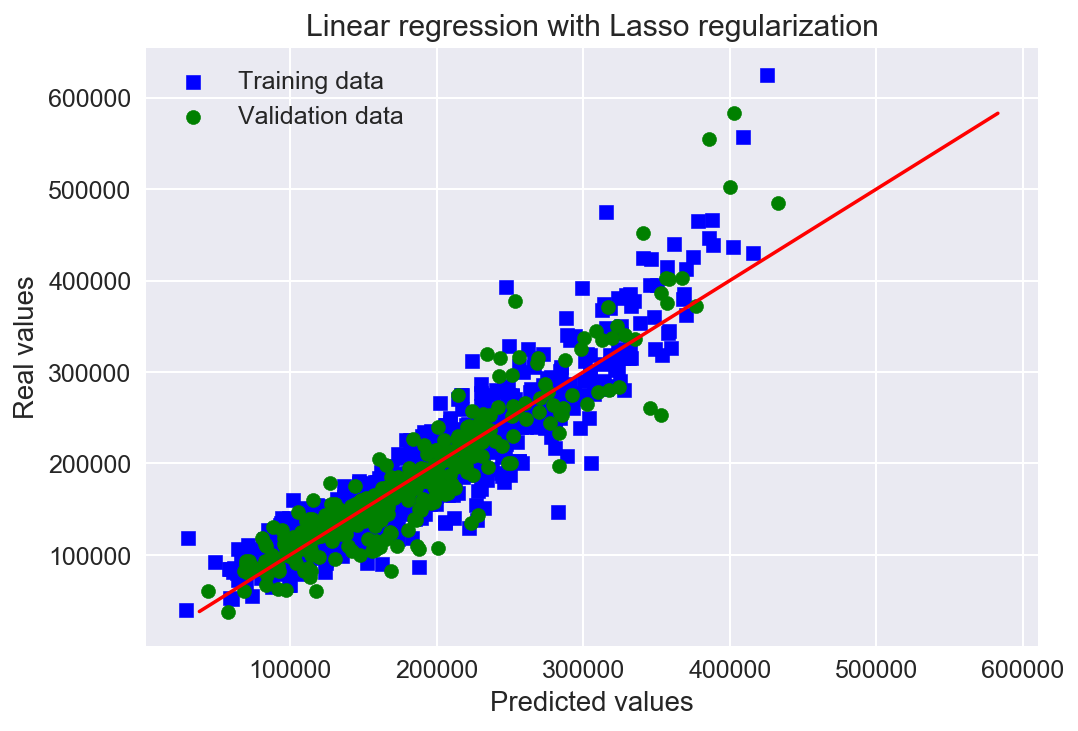

In [1940]:
# Plot predictions
plt.scatter(y_pred_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Linear Regression with ElasticNet regularization (L1 and L2 penalty)

In [1941]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 3)
elasticNet.fit(Xs_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

('Best l1_ratio :', 0.90000000000000002)
('Best alpha :', 1.0)


In [1942]:
print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .70, ratio * .75, ratio * .8, ratio * .85, ratio * .9, \
                                      ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,\
                                    0.3, 0.6, 1, 3, 6], max_iter = 50000, cv = 3)
elasticNet.fit(Xs_train, y_train)
  
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Try again for more precision with l1_ratio centered around 0.9
('Best l1_ratio :', 0.63)
('Best alpha :', 0.29999999999999999)


In [1943]:
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 3)
elasticNet.fit(Xs_train, y_train)   
e_alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", e_alpha )

Now try again for more precision on alpha, with l1_ratio fixed at 0.63 and alpha centered around 0.3
('Best l1_ratio :', 0.63)
('Best alpha :', 0.28499999999999998)


In [1944]:
y_pred_train = elasticNet.predict(Xs_train)
y_pred_test = elasticNet.predict(Xs_test)
elasticNet_score = elasticNet.score(Xs_test, y_test)
elasticNet_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
elasticNet_coef = elasticNet.coef_
print "score:", elasticNet_score
print "RMSE:", elasticNet_rmse
print "Best Coefficients:\n", elasticNet_coef

score: 0.830882093277
RMSE: 33082.9382997
Best Coefficients:
[  2047.34023913   -748.09185896   -742.33449179  -2235.95775537
  -1337.77046547   1552.27161371   2578.67473373  -3583.20304488
   -998.46455829  -2449.73691496  -2038.13614209  -2662.7246082
  -4418.04512742   -666.74368922  -2088.43167082   7040.41922489
  11696.46056584  -6026.32502031  -3107.74922845  -3424.2198957
   -770.20703188   4276.00675264   7695.42828387   1067.47974541
   2286.36353915  -2968.45778587  -4584.94431196  -1933.21837743
  -3131.32796005   1375.93265791   1931.98681263     56.35082843
  -1287.69158093   -132.75276593   5084.24228866    477.83638438
   -190.69819172   1276.96616909     95.64276734   -378.7993608
   2350.00951133   5602.96589027   3989.28739676  11969.34759963
  24538.37374858   7050.79954703   3359.91546082   6213.60147856
  10066.89142113   3945.62676035   4122.28653124]


ElasticNet picked 51 features and eliminated the other 0 features


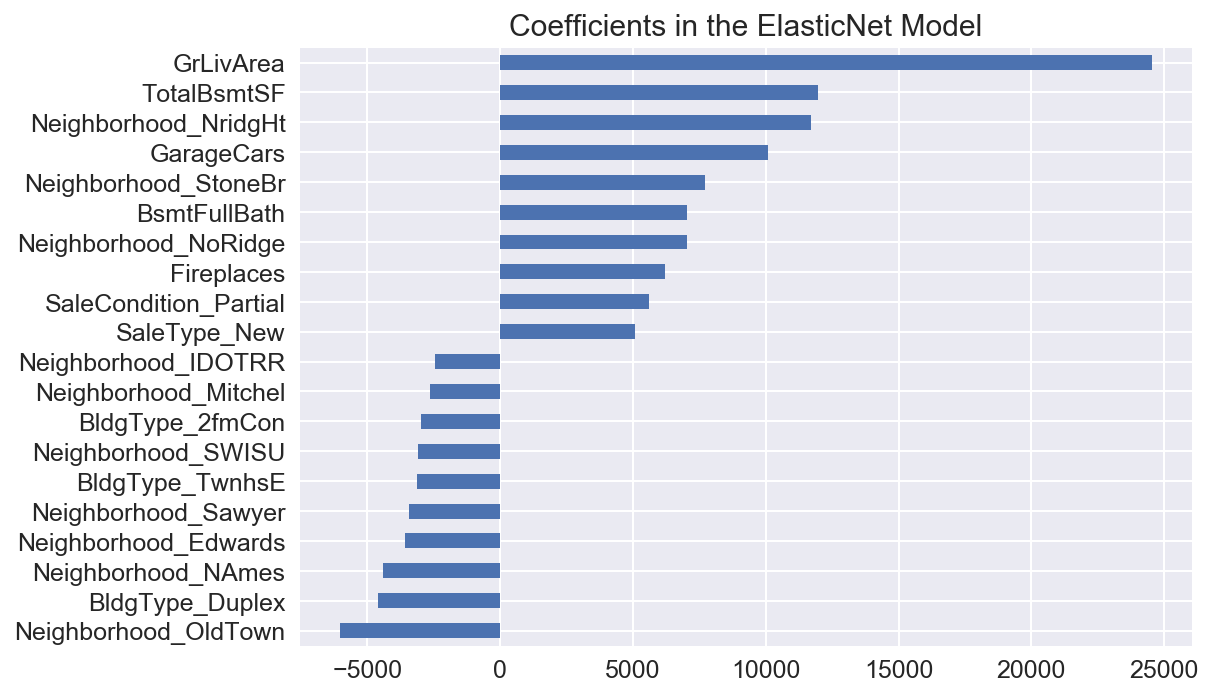

In [1945]:
# Plot important coefficients
coefs = pd.Series(elasticNet_coef, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

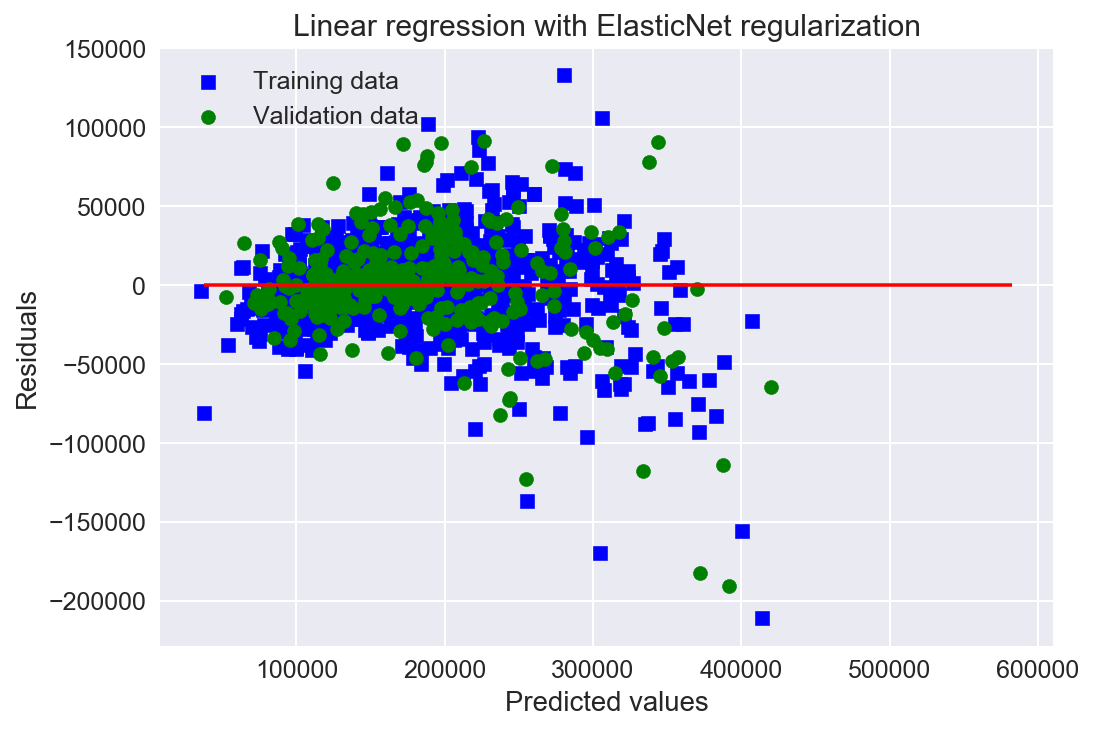

In [1946]:
# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

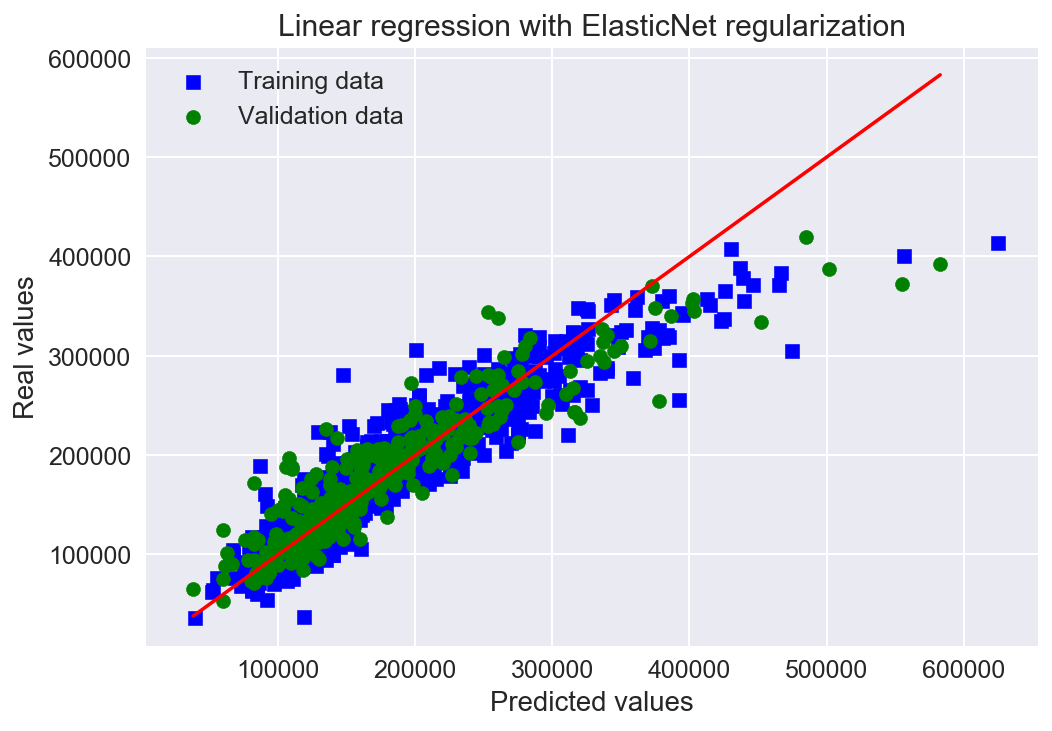

In [1947]:
# Plot predictions
plt.scatter(y_train, y_pred_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_pred_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

In [1948]:
models = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

In [1949]:
results = pd.DataFrame({'models': models,
                        'scores': [linreg_score, ridge_score, lasso_score, elasticNet_score],
                        'rmse': [linreg_rmse, ridge_rmse, lasso_rmse, elasticNet_rmse]})

In [1950]:
results.sort_values('scores', ascending=False)

models          rmse    scores
0      Linear  32552.802840  0.836259
2       Lasso  32554.909998  0.836238
1       Ridge  32872.735423  0.833024
3  ElasticNet  33082.938300  0.830882

### Final Linear Regression Model  without regularization

In [1951]:
X_train = data_pre2010[features]
y_train = data_pre2010.SalePrice.values

X_test = data_2010[features]
y_test = data_2010.SalePrice.values

In [1952]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(1273, 51)
(1273,)
(172, 51)
(172,)


In [1953]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

In [1954]:
final_model = LinearRegression().fit(Xs_train,y_train)

y_pred_train = final_model.predict(Xs_train)
y_pred_test = final_model.predict(Xs_test)
linreg_score_f = final_model.score(Xs_test, y_test)
linreg_coef_f = final_model.coef_
linreg_rmse_f = np.sqrt(mean_squared_error(y_test, y_pred_test))
print "score:", linreg_score_f
# Calculate the MSE of model using sklearn.metrics.mean_squared_error.
print "RMSE:", linreg_rmse_f
print "Model Coefficients:", linreg_coef_f

score: 0.843409823465
RMSE: 31551.6441366
Model Coefficients: [  1950.31548435   -604.69027437   -649.63063736  -5375.04382401
  -4197.22230212  -2217.07755822   -135.72863587  -7733.74684238
  -3272.80056556  -4457.2295547   -2349.49883546  -4819.81853975
 -10010.80453998   -506.32472242  -5899.37256988   4942.33004999
  11550.28669779 -10992.22067577  -5889.63974978  -6530.23107892
  -2689.82881517   2624.77269048   7416.6566322    -472.2976543
   1003.66260869  -3410.76291725  -5676.76679099  -4032.70045102
  -5134.65149867   1958.86199395   2150.78158682   1676.13596955
    638.54287901     52.10036128  13306.49397418   1256.62924326
   2895.81922255   1835.09792846   1226.12101149   -104.67558552
   4636.66466241    306.3598091    4840.3860348   13148.56150196
  28239.7078121    7666.81501874   1653.00299183   4173.81895129
   9538.66485811   3273.98472785   3706.71720244]


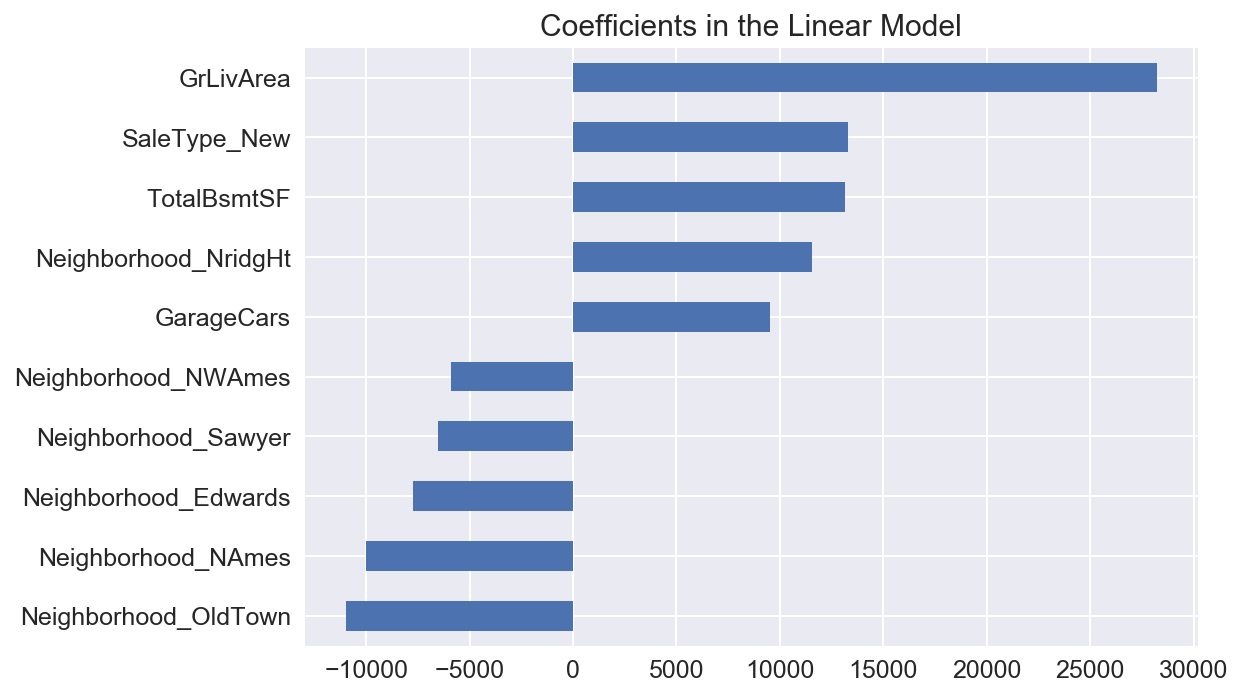

In [1955]:
# Plot important coefficients
coefs = pd.Series(linreg_coef_f, index = X_train.columns)
imp_coefs = pd.concat([coefs.sort_values().head(5),
                     coefs.sort_values().tail(5)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()

In [1956]:
imp_coefs.sort_values(ascending=False)

GrLivArea               28239.707812
SaleType_New            13306.493974
TotalBsmtSF             13148.561502
Neighborhood_NridgHt    11550.286698
GarageCars               9538.664858
Neighborhood_NWAmes     -5899.372570
Neighborhood_Sawyer     -6530.231079
Neighborhood_Edwards    -7733.746842
Neighborhood_NAmes     -10010.804540
Neighborhood_OldTown   -10992.220676
dtype: float64

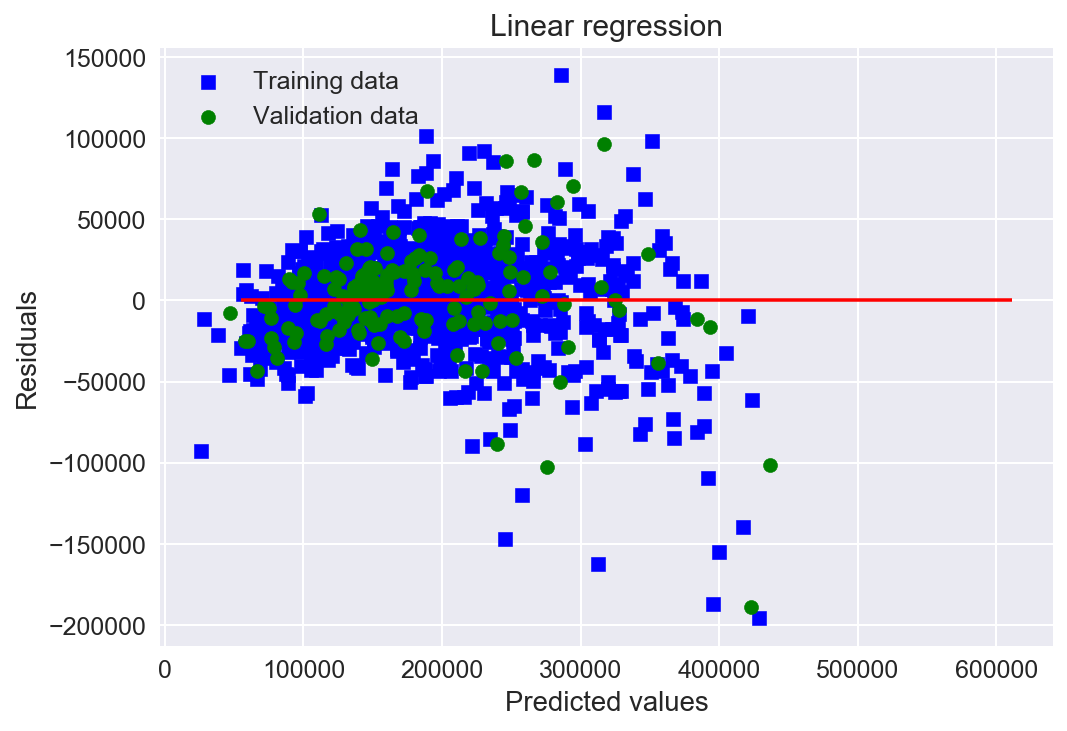

In [1957]:
# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

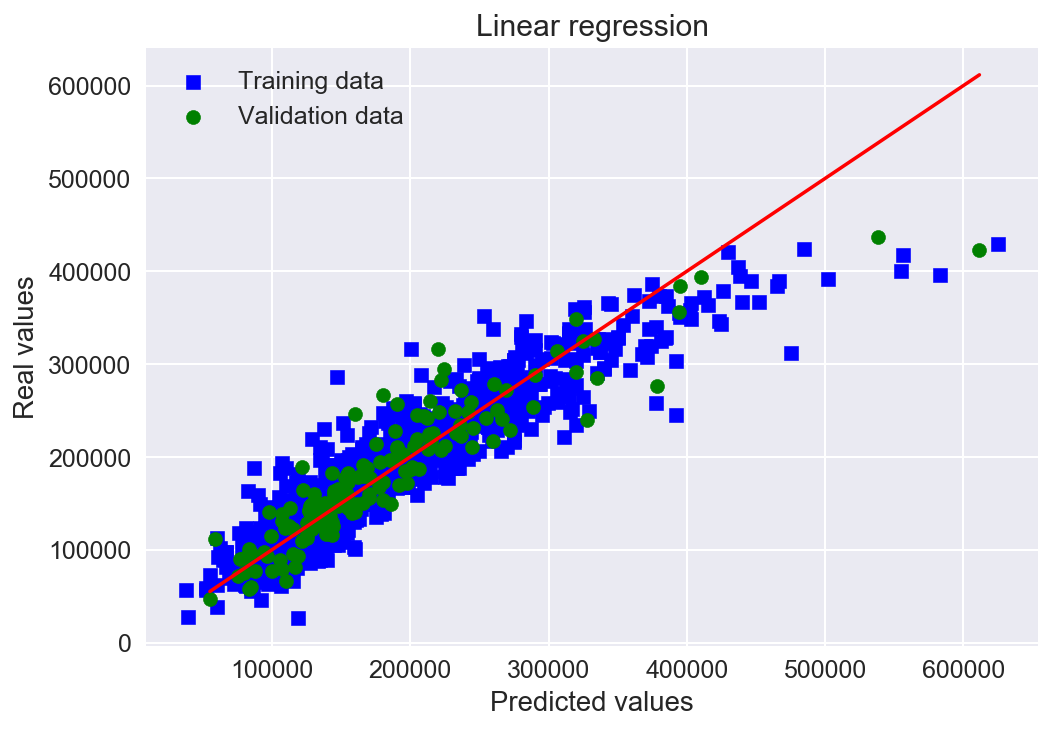

In [1958]:
# Plot predictions
plt.scatter(y_train, y_pred_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_pred_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Calculate the Residuals for the 2nd task

In [1959]:
y_train_2 = y_train - y_pred_train
y_test_2 = y_test - y_pred_test

### Final Linear Regression model with Lasso regularization (L1 penalty)

In [1960]:
final_lasso = lasso.fit(Xs_train, y_train)
l_alpha = final_lasso.alpha_
print("Best alpha :", l_alpha)
y_pred_train = final_lasso.predict(Xs_train)
y_pred_test = final_lasso.predict(Xs_test)
lasso_score = final_lasso.score(Xs_test, y_test)
lasso_coef = final_lasso.coef_
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print "score:", lasso_score
print "RMSE:", lasso_rmse
print "Best Coefficients:\n", lasso_coef

('Best alpha :', 1.3999999999999999)
score: 0.843541098134
RMSE: 31538.4159757
Best Coefficients:
[  1947.62134752   -590.46172395   -609.67806173  -5285.83968824
  -4138.31596792  -2089.18062349    -55.65563912  -7625.61245683
  -3175.60609347  -4396.29832733  -2310.73002096  -4741.93311788
  -9859.00680644   -481.08379856  -5806.93138398   5005.01163973
  11633.30733863 -10877.96613954  -5832.8828284   -6440.05571565
  -2611.60468518   2714.85178185   7459.49326222   -407.70741961
   1039.54569601  -3408.45215874  -5675.77909413  -4023.40520529
  -5109.56159877   1954.23629126   2146.66916561   1670.64013435
    635.19155371     48.4622387   13294.51527717   1253.61606082
   2882.90995218   1834.02463165   1224.36890779   -105.20119174
   4635.24835387    312.44502827   4836.00514043  13155.38074121
  28238.30523008   7660.64386733   1656.33683883   4176.9991401
   9544.67910969   3276.1667289    3702.73353474]


Lasso picked 51 features and eliminated the other 0 features


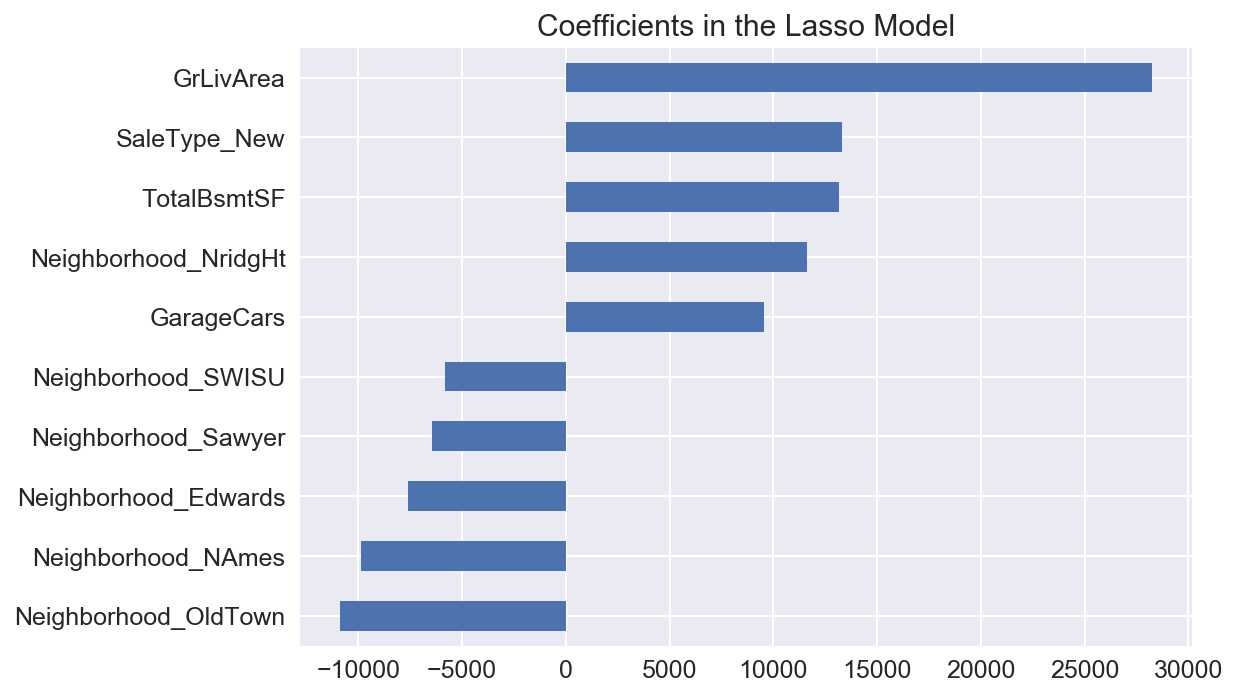

GrLivArea               28238.305230
SaleType_New            13294.515277
TotalBsmtSF             13155.380741
Neighborhood_NridgHt    11633.307339
GarageCars               9544.679110
Neighborhood_SWISU      -5832.882828
Neighborhood_Sawyer     -6440.055716
Neighborhood_Edwards    -7625.612457
Neighborhood_NAmes      -9859.006806
Neighborhood_OldTown   -10877.966140
dtype: float64


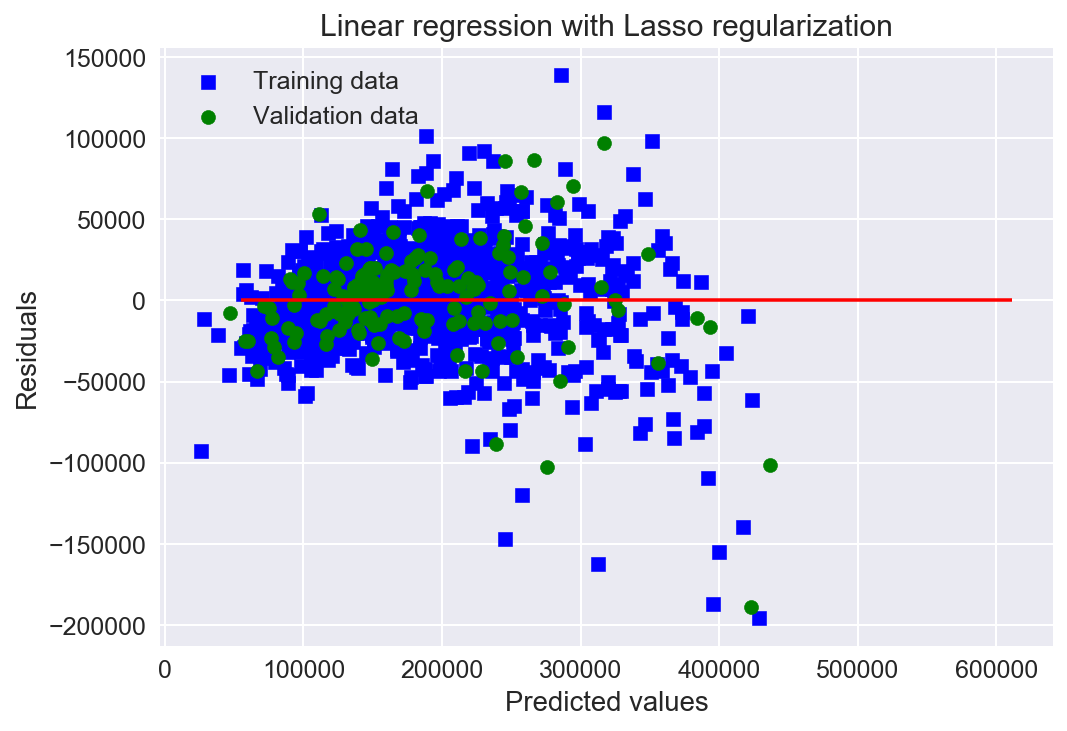

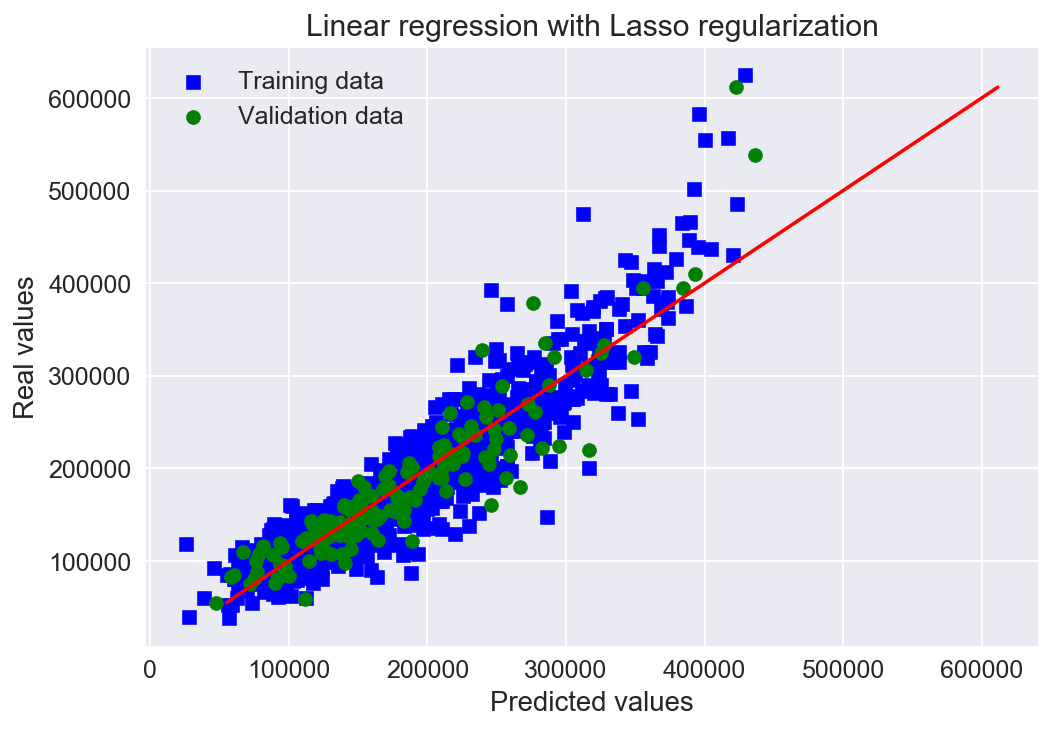

In [1961]:
# Plot important coefficients
coefs = pd.Series(lasso_coef, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(5),
                     coefs.sort_values().tail(5)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()
print imp_coefs.sort_values(ascending=False)

# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

# Plot predictions
plt.scatter(y_pred_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Calculate the Residuals for the 2nd task

In [1962]:
y_train_2lasso = y_train - y_pred_train
y_test_2lasso = y_test - y_pred_test

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [1963]:
# Load the data
house = pd.read_csv('./housing.csv')

In [1964]:
house.shape

(1460, 81)

In [1965]:
# Drop the "Id" column
house.drop('Id', axis=1, inplace=True)

In [1966]:
# eliminate outliers
house = house[house.GrLivArea < 4000]

In [1967]:
# remove any houses that are not residential from the dataset
house = house[house.MSZoning != 'C (all)']

In [1968]:
house.shape

(1446, 80)

#### Check missing values

In [1969]:
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1441  0.996542
MiscFeature    1394  0.964039
Alley          1357  0.938451
Fence          1169  0.808437
FireplaceQu     681  0.470954
LotFrontage     259  0.179115
GarageType       79  0.054633
GarageCond       79  0.054633
GarageFinish     79  0.054633
GarageQual       79  0.054633
GarageYrBlt      79  0.054633
BsmtFinType2     38  0.026279
BsmtExposure     38  0.026279
BsmtQual         37  0.025588
BsmtCond         37  0.025588
BsmtFinType1     37  0.025588
MasVnrArea        8  0.005533
MasVnrType        8  0.005533
Electrical        1  0.000692
RoofMatl          0  0.000000

In [1970]:
#dealing with missing data
house = house.drop((missing_data[missing_data['Total'] >= 259]).index,1)
house = house.drop(house.loc[house['Electrical'].isnull()].index)

In [1971]:
# BsmtQual: data description says NA for basement features is "no basement"
house.loc[:, "BsmtQual"] = house.loc[:, "BsmtQual"].fillna("No")


In [1972]:
house.loc[:, "BsmtFinType1"] = house.loc[:, "BsmtFinType1"].fillna("No")


In [1973]:
house.loc[:, "BsmtCond"] = house.loc[:, "BsmtCond"].fillna("No")


In [1974]:
# GarageQual: data description says NA for basement features is "no basement"
house.loc[:, "GarageQual"] = house.loc[:, "GarageQual"].fillna("No")


In [1975]:
house.loc[:, "GarageCond"] = house.loc[:, "GarageQual"].fillna("No")


In [1976]:
not_fixed = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'ExterQual', 'BsmtQual', 'BsmtFinType1',\
                  'BsmtCond', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',\
                  'GarageQual', 'GarageCond', 'PavedDrive','OverallQual', 'YrSold']

In [1977]:
dumm_not_fixed = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'ExterQual', 'BsmtQual', 'BsmtFinType1',\
                  'BsmtCond', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',\
                  'GarageQual', 'GarageCond', 'PavedDrive']

In [1978]:
not_fixed_df = house[not_fixed]

#### Transform categorical variable into binary

In [1979]:
not_fixed_dum = pd.get_dummies(not_fixed_df, columns= dumm_not_fixed)

In [1980]:
# Create 2006 - 2009 dataframe to fit the final model
data_pre2010 = not_fixed_dum[not_fixed_dum.YrSold != 2010]
data_pre2010['Target'] = y_train_2lasso
data_pre2010.head()

/Users/iurigo/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


OverallQual  YrSold  Utilities_AllPub  Utilities_NoSeWa  RoofStyle_Flat  \
0            7    2008                 1                 0               0   
1            6    2007                 1                 0               0   
2            7    2008                 1                 0               0   
3            7    2006                 1                 0               0   
4            8    2008                 1                 0               0   

   RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  \
0                1                  0              0                  0   
1                1                  0              0                  0   
2                1                  0              0                  0   
3                1                  0              0                  0   
4                1                  0              0                  0   

   RoofStyle_Shed      ...       GarageCond_Ex  GarageCond_Fa  GarageCond_Gd  \
0               0      ...                   0              0              0   
1               0      ...                   0              0              0   
2               0      ...                   0              0              0   
3               0      ...                   0              0              0   
4               0      ...                   0              0              0   

   GarageCond_No  GarageCond_Po  GarageCond_TA  PavedDrive_N  PavedDrive_P  \
0              0              0              1             0             0   
1              0              0              1             0             0   
2              0              0              1             0             0   
3              0              0              1             0             0   
4              0              0              1             0             0   

   PavedDrive_Y        Target  
0             1   7334.485596  
1             1 -21825.881432  
2             1   9130.715271  
3             1 -68242.756516  
4             1 -55368.328944  

[5 rows x 98 columns]

In [1981]:
# Create 2010 dataframe to test the final model
data_2010 = not_fixed_dum[not_fixed_dum.YrSold == 2010]
data_2010['Target'] = y_test_2lasso
data_2010.head()

/Users/iurigo/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


OverallQual  YrSold  Utilities_AllPub  Utilities_NoSeWa  RoofStyle_Flat  \
16            6    2010                 1                 0               0   
24            5    2010                 1                 0               0   
26            5    2010                 1                 0               0   
27            8    2010                 1                 0               0   
33            5    2010                 1                 0               0   

    RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  \
16                1                  0              0                  0   
24                1                  0              0                  0   
26                1                  0              0                  0   
27                1                  0              0                  0   
33                0                  0              1                  0   

    RoofStyle_Shed      ...       GarageCond_Ex  GarageCond_Fa  GarageCond_Gd  \
16               0      ...                   0              0              0   
24               0      ...                   0              0              0   
26               0      ...                   0              0              0   
27               0      ...                   0              0              0   
33               0      ...                   0              0              0   

    GarageCond_No  GarageCond_Po  GarageCond_TA  PavedDrive_N  PavedDrive_P  \
16              0              0              1             0             0   
24              0              0              1             0             0   
26              0              0              1             0             0   
27              0              0              1             0             0   
33              0              0              1             0             0   

    PavedDrive_Y        Target  
16             1  -2923.391075  
24             1  -6332.648849  
26             1   8281.152638  
27             1  -8427.039488  
33             1 -25909.380196  

[5 rows x 98 columns]

In [1982]:
# Create 2006 - 2008 dataframe to fit different models
data_pre2009 = data_pre2010[data_pre2010.YrSold != 2009]
data_pre2009.head()

OverallQual  YrSold  Utilities_AllPub  Utilities_NoSeWa  RoofStyle_Flat  \
0            7    2008                 1                 0               0   
1            6    2007                 1                 0               0   
2            7    2008                 1                 0               0   
3            7    2006                 1                 0               0   
4            8    2008                 1                 0               0   

   RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  \
0                1                  0              0                  0   
1                1                  0              0                  0   
2                1                  0              0                  0   
3                1                  0              0                  0   
4                1                  0              0                  0   

   RoofStyle_Shed      ...       GarageCond_Ex  GarageCond_Fa  GarageCond_Gd  \
0               0      ...                   0              0              0   
1               0      ...                   0              0              0   
2               0      ...                   0              0              0   
3               0      ...                   0              0              0   
4               0      ...                   0              0              0   

   GarageCond_No  GarageCond_Po  GarageCond_TA  PavedDrive_N  PavedDrive_P  \
0              0              0              1             0             0   
1              0              0              1             0             0   
2              0              0              1             0             0   
3              0              0              1             0             0   
4              0              0              1             0             0   

   PavedDrive_Y        Target  
0             1   7334.485596  
1             1 -21825.881432  
2             1   9130.715271  
3             1 -68242.756516  
4             1 -55368.328944  

[5 rows x 98 columns]

In [1983]:
# Create 2009 dataframe to choose the final model
data_2009 = data_pre2010[data_pre2010.YrSold == 2009]
data_2009.head()

OverallQual  YrSold  Utilities_AllPub  Utilities_NoSeWa  RoofStyle_Flat  \
5             5    2009                 1                 0               0   
7             7    2009                 1                 0               0   
19            5    2009                 1                 0               0   
25            8    2009                 1                 0               0   
36            5    2009                 1                 0               0   

    RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  \
5                 1                  0              0                  0   
7                 1                  0              0                  0   
19                0                  0              1                  0   
25                1                  0              0                  0   
36                1                  0              0                  0   

    RoofStyle_Shed      ...       GarageCond_Ex  GarageCond_Fa  GarageCond_Gd  \
5                0      ...                   0              0              0   
7                0      ...                   0              0              0   
19               0      ...                   0              0              0   
25               0      ...                   0              0              0   
36               0      ...                   0              0              0   

    GarageCond_No  GarageCond_Po  GarageCond_TA  PavedDrive_N  PavedDrive_P  \
5               0              0              1             0             0   
7               0              0              1             0             0   
19              0              0              1             0             0   
25              0              0              1             0             0   
36              0              0              1             0             0   

    PavedDrive_Y        Target  
5              1 -16442.375472  
7              1 -39714.994618  
19             1  29082.272112  
25             1 -26317.577682  
36             1 -22756.228124  

[5 rows x 98 columns]

#### Modeling

In [1984]:
X_train = data_pre2009.drop(['YrSold', 'Target'], axis=1)
y_train = data_pre2009.Target.values

X_test = data_2009.drop(['YrSold', 'Target'], axis=1)
y_test = data_2009.Target.values

In [1985]:
# MinMax transformation
mm = MinMaxScaler()
Xm_train = mm.fit_transform(X_train)
Xm_test = mm.fit_transform(X_test)

In [1986]:
print Xm_train.shape
print y_train.shape
print Xm_test.shape
print y_test.shape

(937, 96)
(937,)
(336, 96)
(336,)


#### Linear Regression without regularization

In [1987]:
model = LinearRegression().fit(Xm_train, y_train)

y_pred_train = model.predict(Xm_train)
y_pred_test = model.predict(Xm_test)
linreg_score = model.score(Xm_test, y_test)
linreg_coef = model.coef_
linreg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print "score:", linreg_score
# Calculate the MSE of model using sklearn.metrics.mean_squared_error.
print "RMSE:", linreg_rmse


score: -9.58052512659e+26
RMSE: 9.65999391201e+17


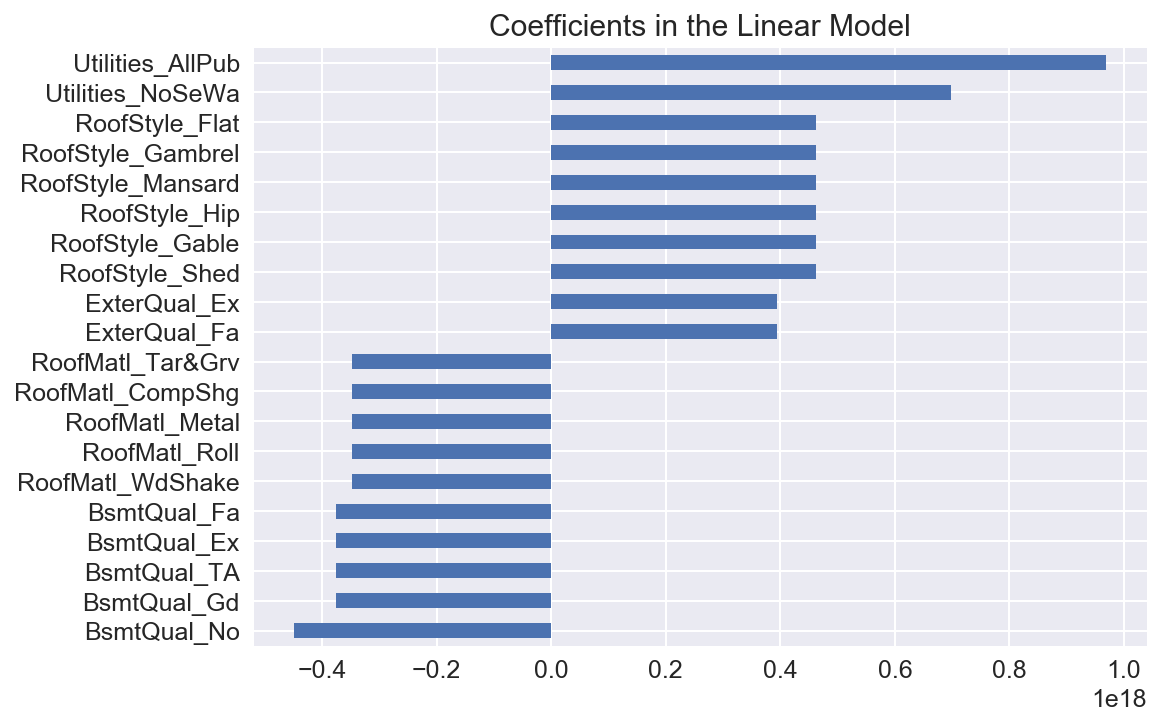

Utilities_AllPub     9.687301e+17
Utilities_NoSeWa     6.973967e+17
RoofStyle_Flat       4.620283e+17
RoofStyle_Gambrel    4.620283e+17
RoofStyle_Mansard    4.620283e+17
RoofStyle_Hip        4.620283e+17
RoofStyle_Gable      4.620283e+17
RoofStyle_Shed       4.620283e+17
ExterQual_Ex         3.950139e+17
ExterQual_Fa         3.950139e+17
RoofMatl_Tar&Grv    -3.482025e+17
RoofMatl_CompShg    -3.482025e+17
RoofMatl_Metal      -3.482025e+17
RoofMatl_Roll       -3.482025e+17
RoofMatl_WdShake    -3.482025e+17
BsmtQual_Fa         -3.750938e+17
BsmtQual_Ex         -3.750938e+17
BsmtQual_TA         -3.750938e+17
BsmtQual_Gd         -3.750938e+17
BsmtQual_No         -4.486369e+17
dtype: float64


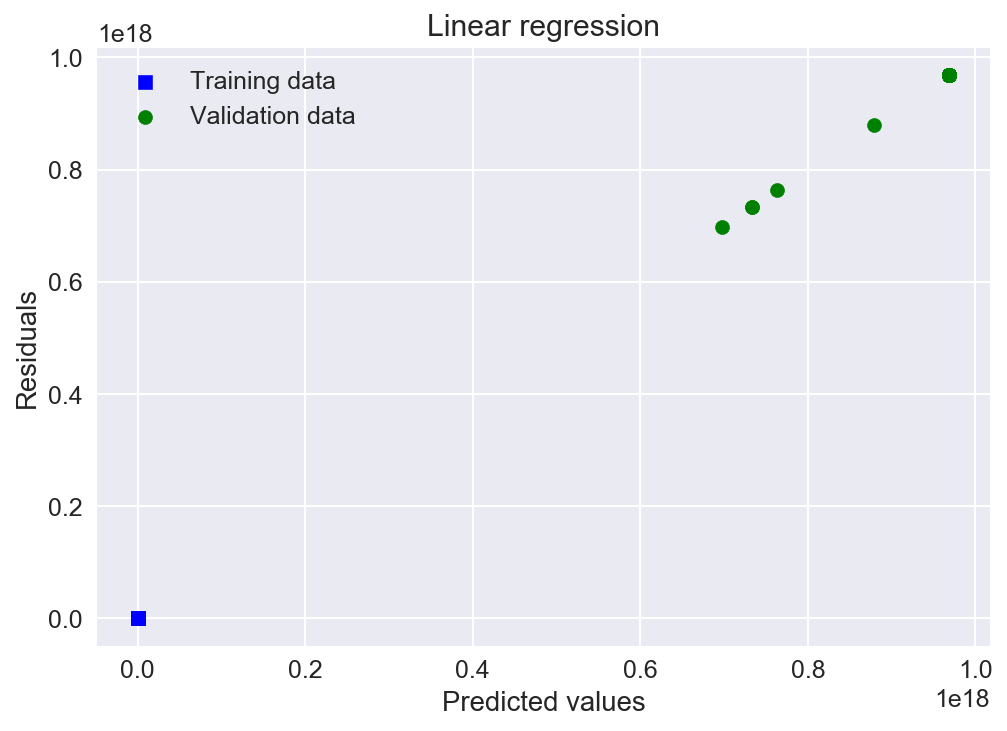

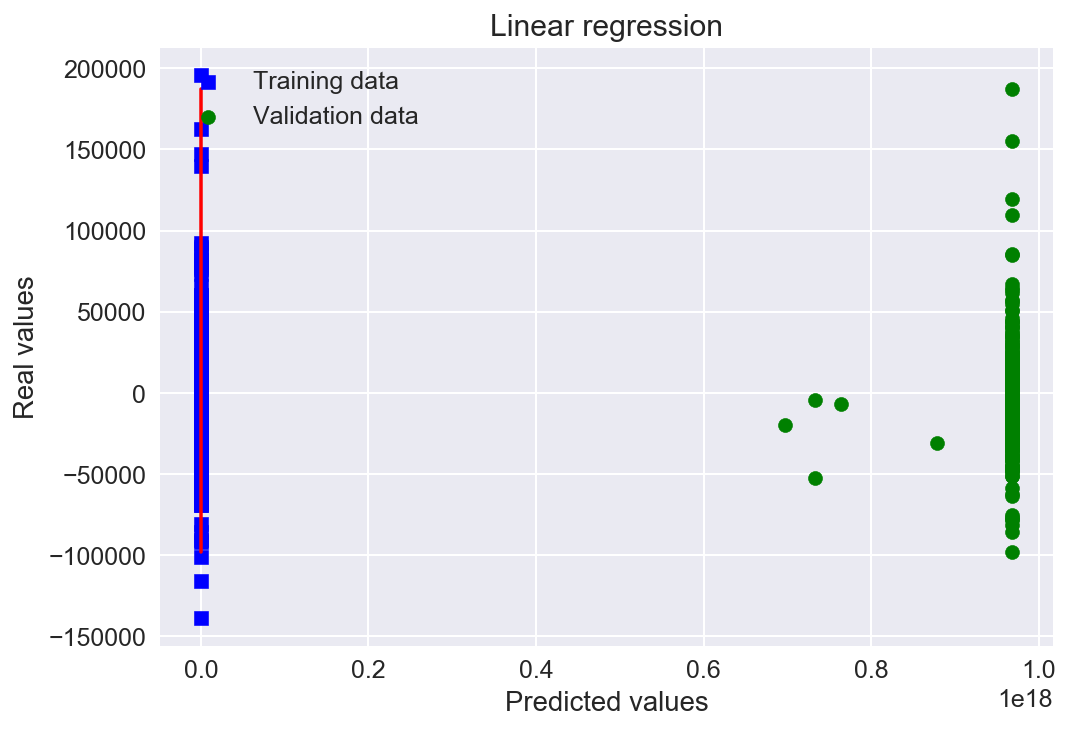

In [1988]:
# Plot important coefficients
coefs = pd.Series(linreg_coef, index = X_train.columns)

imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()
print imp_coefs.sort_values(ascending=False)

# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

# Plot predictions
plt.scatter(y_pred_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Linear Regression with Ridge regularization (L2 penalty)

('Best alpha :', 10.0)
Try again for more precision with alphas centered around 10.0
('Best alpha :', 14.0)
score: 0.164734269971
RMSE: 28522.9556853
Ridge picked 91 features and eliminated the other 5 features


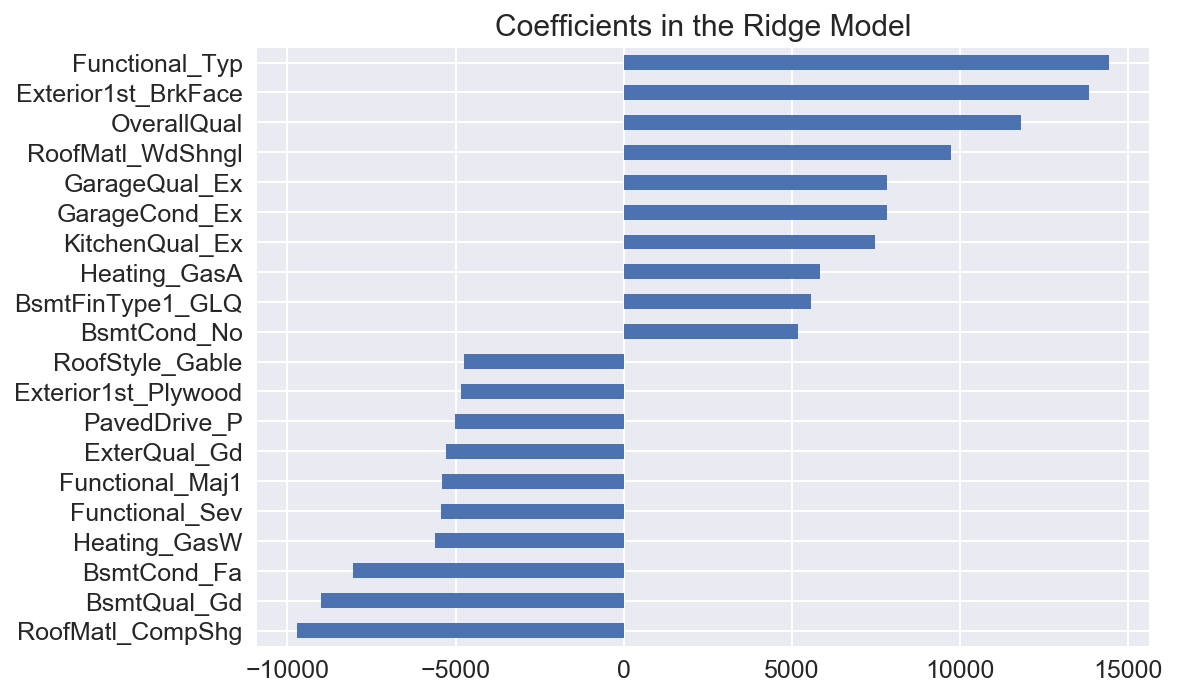

Functional_Typ         14422.190040
Exterior1st_BrkFace    13832.650710
OverallQual            11817.239874
RoofMatl_WdShngl        9715.699199
GarageQual_Ex           7823.165465
GarageCond_Ex           7823.165465
KitchenQual_Ex          7481.729158
Heating_GasA            5837.626749
BsmtFinType1_GLQ        5559.508013
BsmtCond_No             5183.704932
RoofStyle_Gable        -4756.733183
Exterior1st_Plywood    -4831.897043
PavedDrive_P           -5026.304753
ExterQual_Gd           -5270.646268
Functional_Maj1        -5414.514174
Functional_Sev         -5429.272700
Heating_GasW           -5610.432584
BsmtCond_Fa            -8055.801738
BsmtQual_Gd            -8987.302254
RoofMatl_CompShg       -9704.804864
dtype: float64


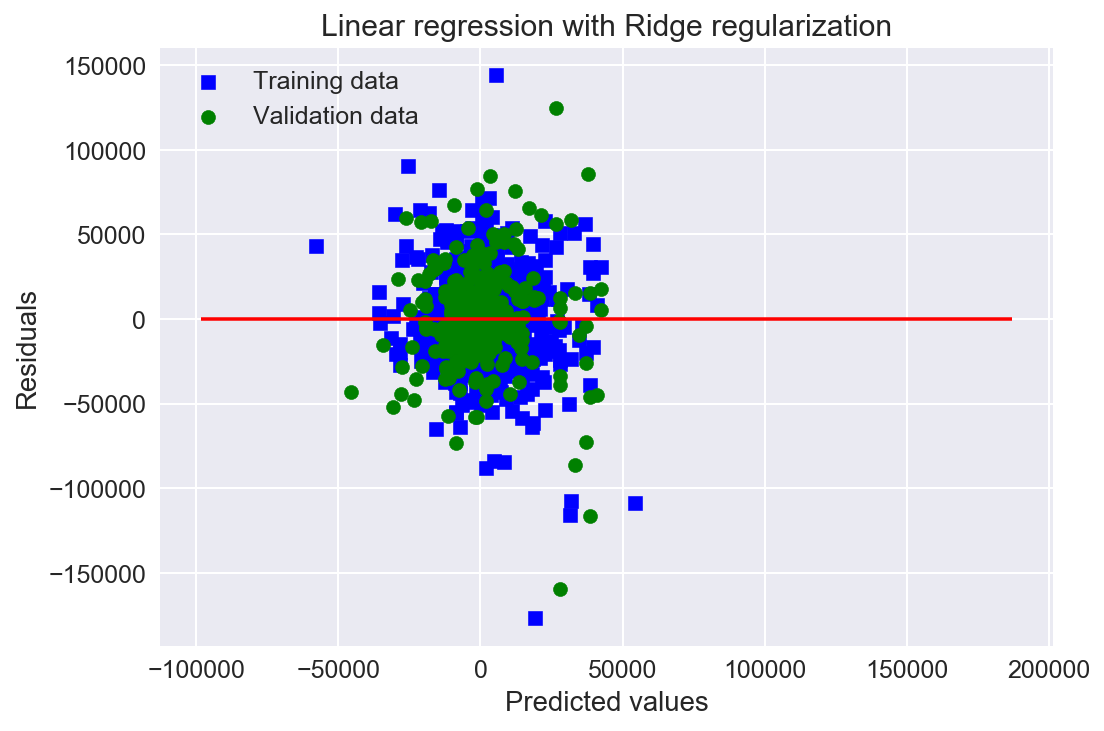

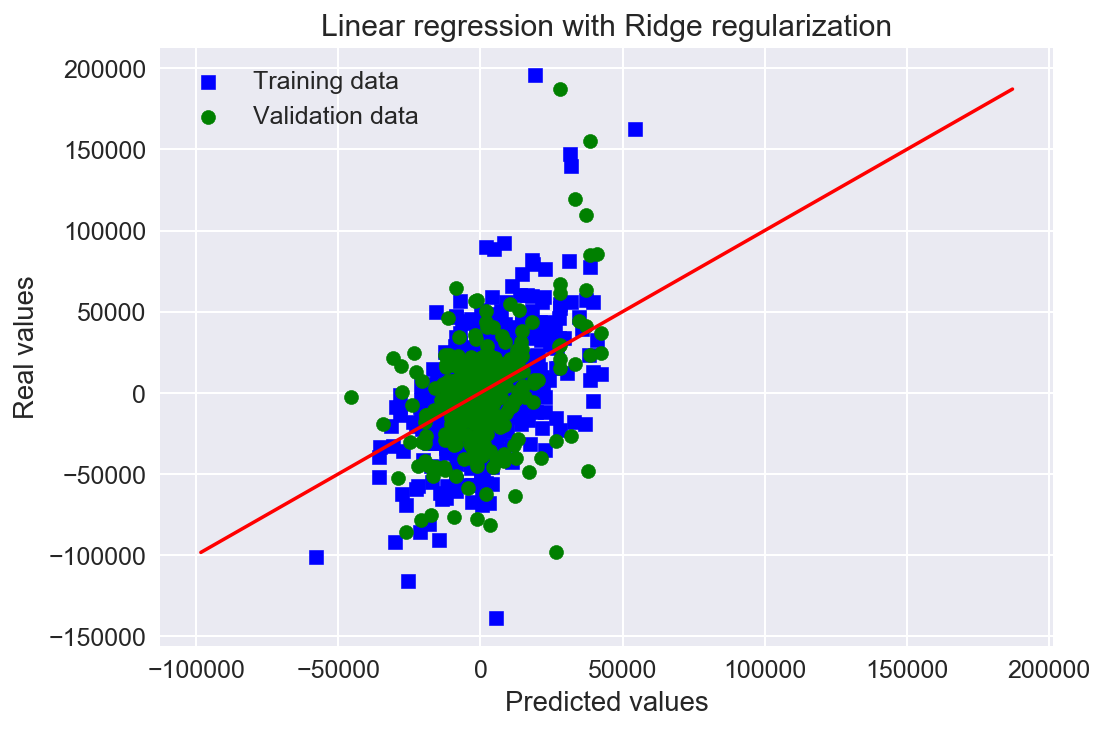

In [1989]:


ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(Xm_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 3)
ridge.fit(Xm_train, y_train)
r_alpha = ridge.alpha_
print("Best alpha :", r_alpha)

y_pred_train = ridge.predict(Xm_train)
y_pred_test = ridge.predict(Xm_test)
ridge_score = ridge.score(Xm_test, y_test)
ridge_coef = ridge.coef_
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print "score:", ridge_score
print "RMSE:", ridge_rmse

# Plot important coefficients
coefs = pd.Series(ridge_coef, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()
print imp_coefs.sort_values(ascending=False)

# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

# Plot predictions
plt.scatter(y_pred_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Linear Regression with Lasso regularization (L1 penalty)


('Best alpha :', 1.0)
Try again for more precision with alphas centered around 1.0
('Best alpha :', 1.3999999999999999)
score: 0.123094080254
RMSE: 29225.2810647
Lasso picked 80 features and eliminated the other 16 features


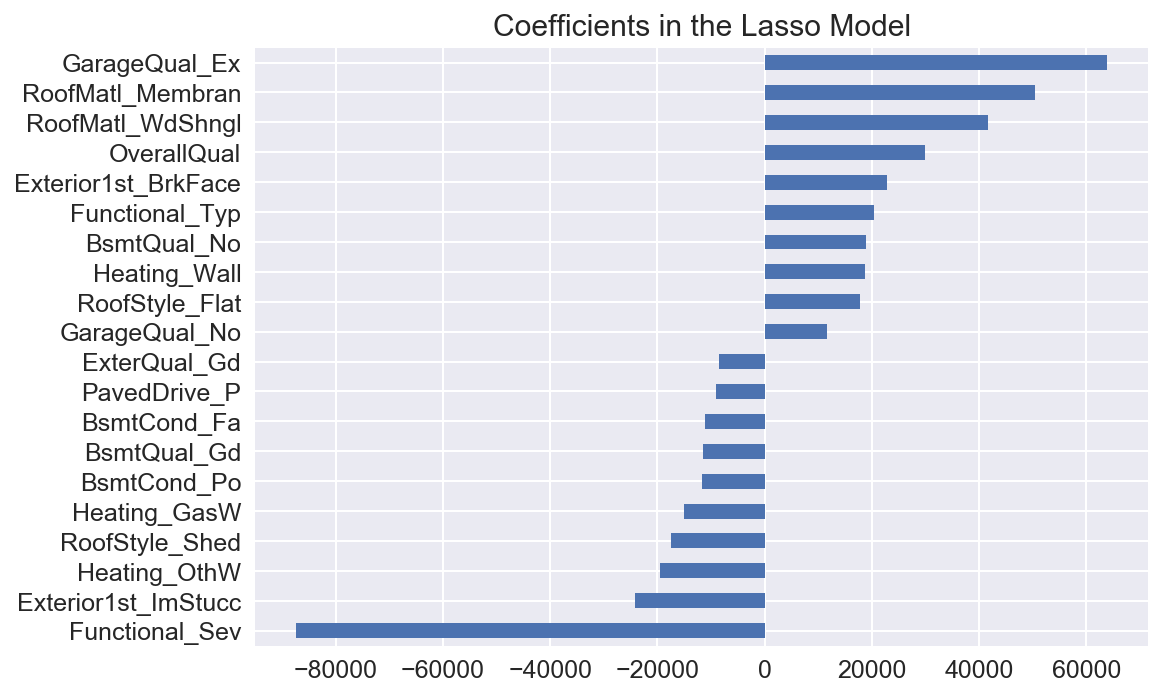

GarageQual_Ex          63970.460317
RoofMatl_Membran       50394.846845
RoofMatl_WdShngl       41673.314070
OverallQual            29971.056190
Exterior1st_BrkFace    22807.474197
Functional_Typ         20486.667272
BsmtQual_No            19002.222931
Heating_Wall           18734.103260
RoofStyle_Flat         17708.318087
GarageQual_No          11566.656955
ExterQual_Gd           -8593.738236
PavedDrive_P           -9003.570716
BsmtCond_Fa           -11219.432873
BsmtQual_Gd           -11497.632931
BsmtCond_Po           -11643.303724
Heating_GasW          -15063.667392
RoofStyle_Shed        -17542.451931
Heating_OthW          -19506.343698
Exterior1st_ImStucc   -24267.180884
Functional_Sev        -87471.240829
dtype: float64


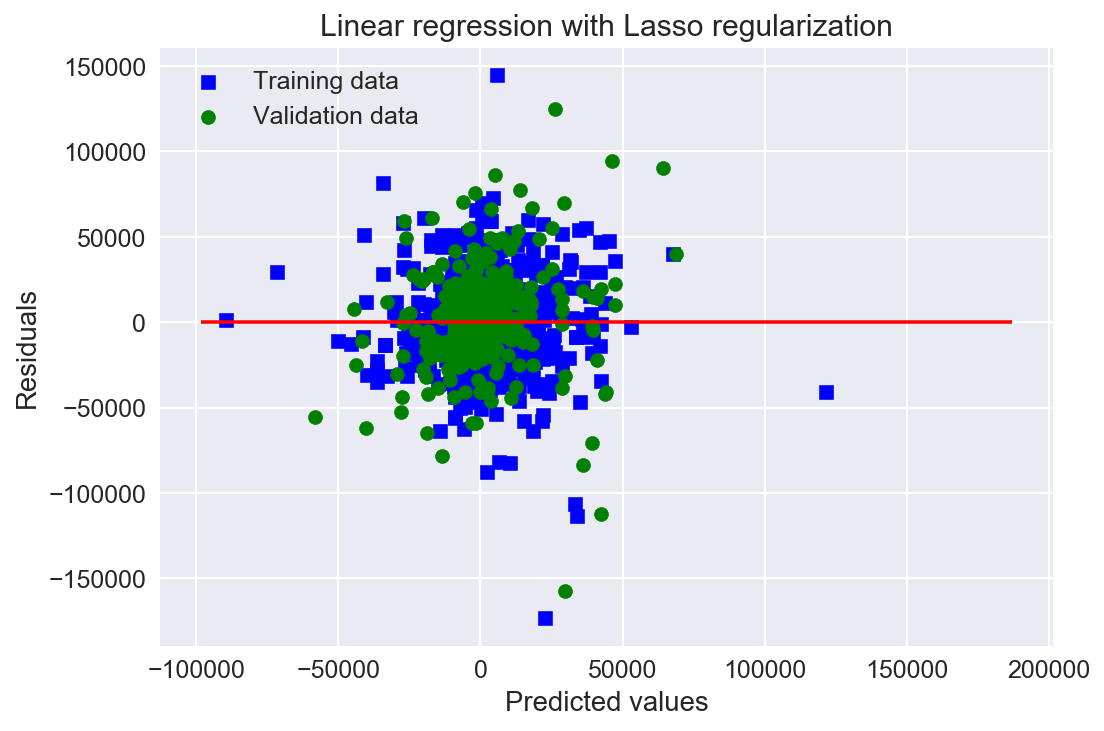

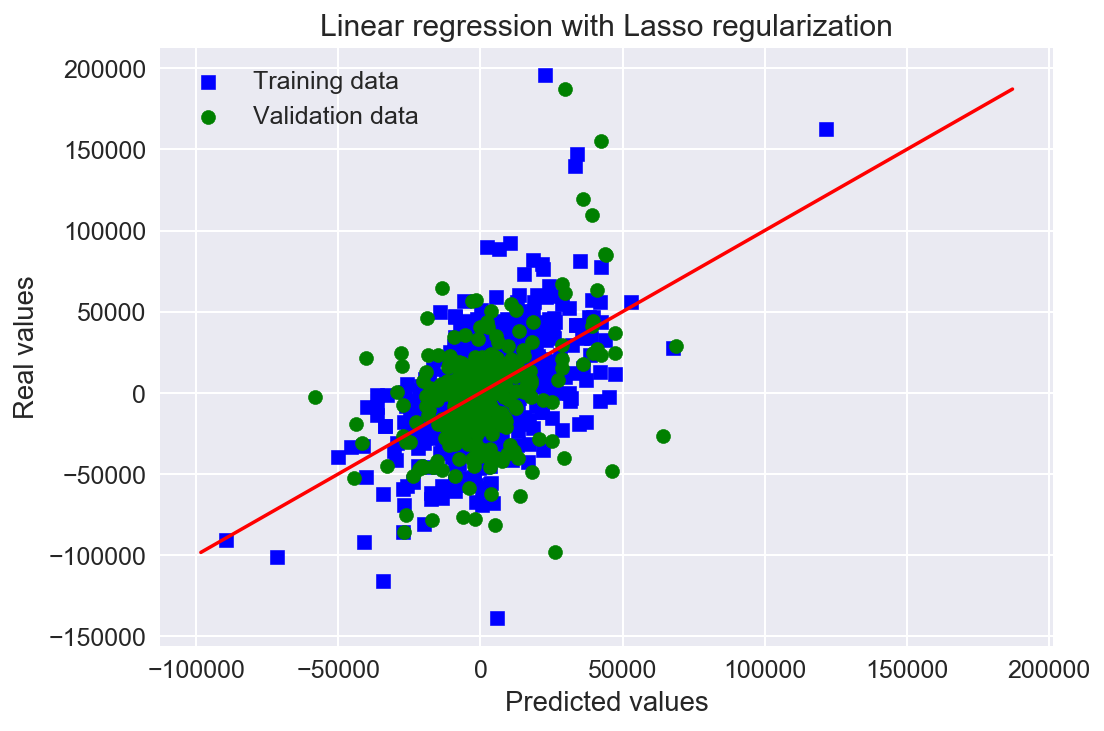

In [1990]:

lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 3)
lasso.fit(Xm_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 3)
lasso.fit(Xm_train, y_train)
l_alpha = lasso.alpha_
print("Best alpha :", l_alpha)


y_pred_train = lasso.predict(Xm_train)
y_pred_test = lasso.predict(Xm_test)
lasso_score = lasso.score(Xm_test, y_test)
lasso_coef = lasso.coef_
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print "score:", lasso_score
print "RMSE:", lasso_rmse

# Plot important coefficients
coefs = pd.Series(lasso_coef, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()
print imp_coefs.sort_values(ascending=False)

# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

# Plot predictions
plt.scatter(y_pred_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Linear Regression with ElasticNet regularization (L1 and L2 penalty)

('Best l1_ratio :', 0.59999999999999998)
('Best alpha :', 0.10000000000000001)
Try again for more precision with l1_ratio centered around 0.6
('Best l1_ratio :', 0.63)
('Best alpha :', 0.10000000000000001)
Now try again for more precision on alpha, with l1_ratio fixed at 0.63 and alpha centered around 0.1
('Best l1_ratio :', 0.63)
('Best alpha :', 0.10000000000000001)
score: 0.169267460928
RMSE: 28445.4498609
ElasticNet picked 91 features and eliminated the other 5 features


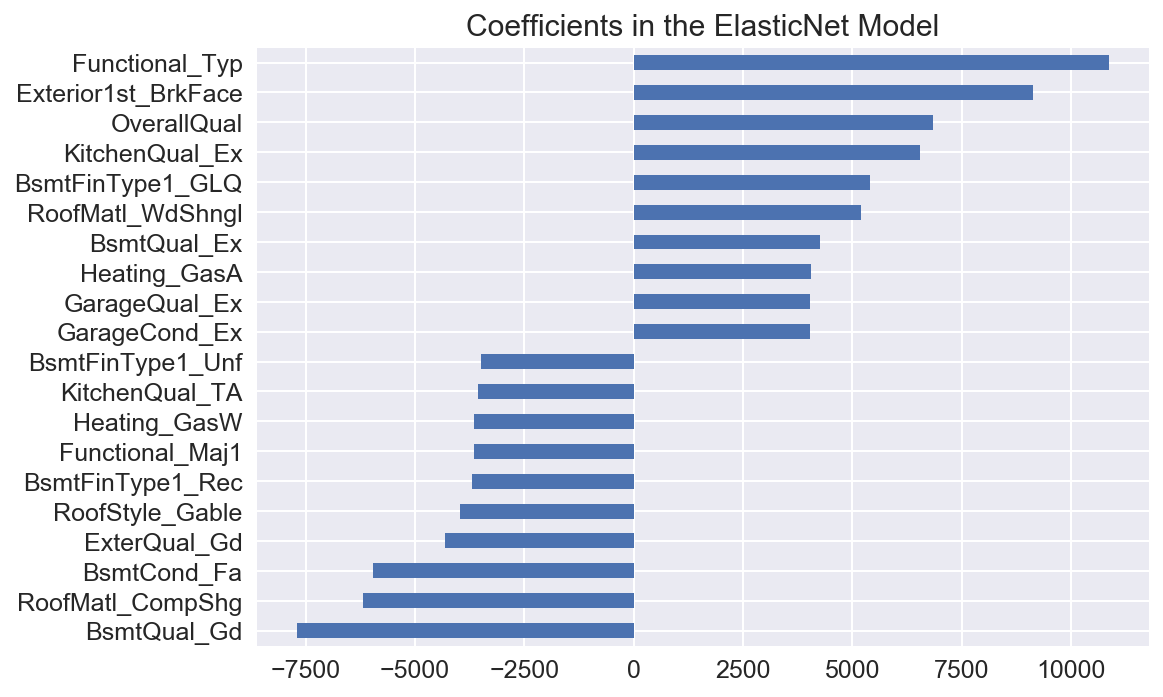

Functional_Typ         10860.525151
Exterior1st_BrkFace     9136.576339
OverallQual             6843.961746
KitchenQual_Ex          6546.713187
BsmtFinType1_GLQ        5410.741222
RoofMatl_WdShngl        5189.399307
BsmtQual_Ex             4250.957933
Heating_GasA            4041.522113
GarageQual_Ex           4020.045952
GarageCond_Ex           4020.045912
BsmtFinType1_Unf       -3481.719003
KitchenQual_TA         -3564.754723
Heating_GasW           -3647.349566
Functional_Maj1        -3651.111797
BsmtFinType1_Rec       -3704.176294
RoofStyle_Gable        -3964.772494
ExterQual_Gd           -4307.267295
BsmtCond_Fa            -5963.774094
RoofMatl_CompShg       -6179.064533
BsmtQual_Gd            -7692.059184
dtype: float64


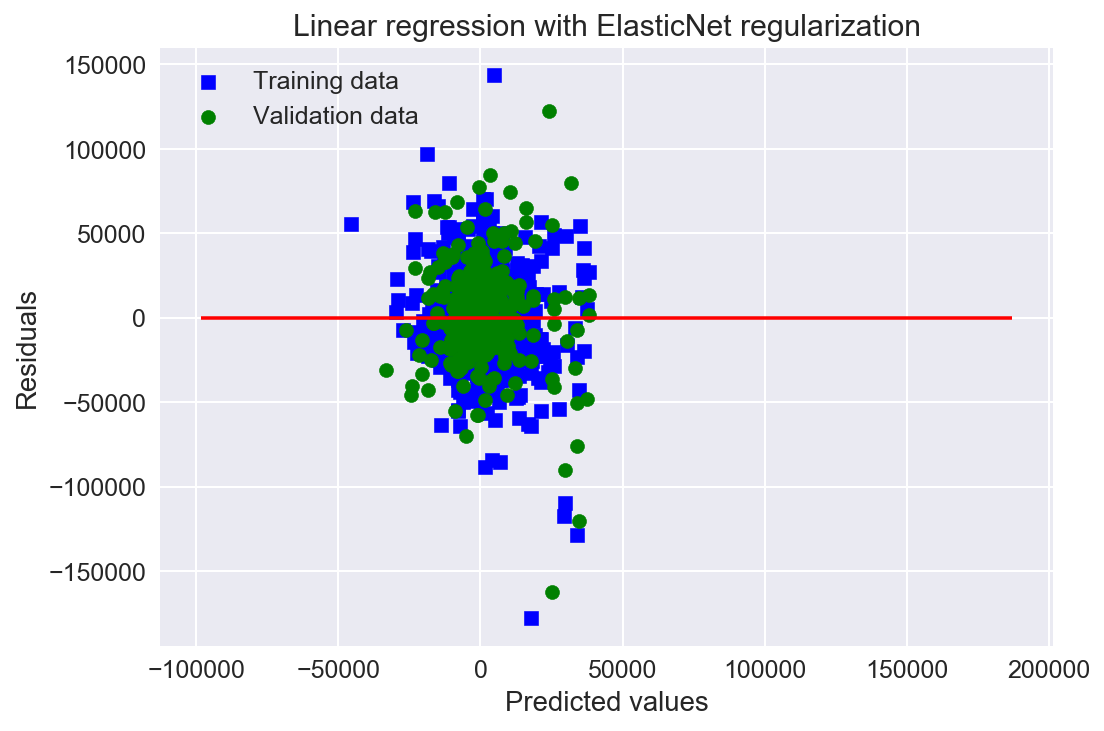

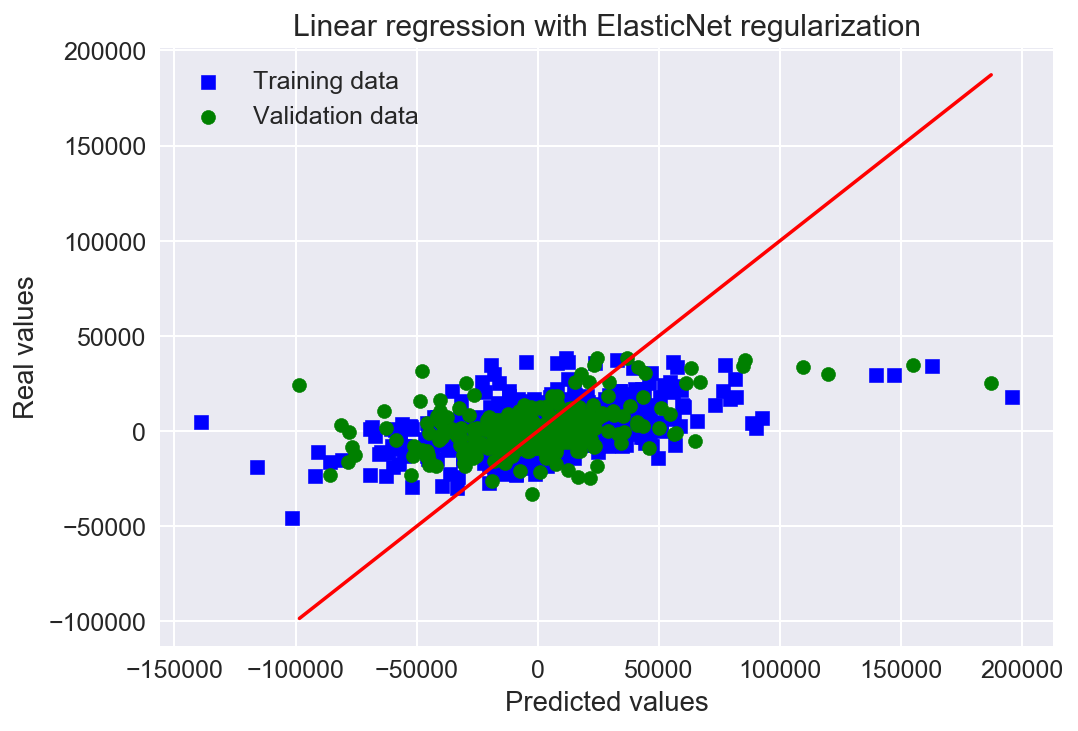

In [1991]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 3)
elasticNet.fit(Xm_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .70, ratio * .75, ratio * .8, ratio * .85, ratio * .9, \
                                      ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,\
                                    0.3, 0.6, 1, 3, 6], max_iter = 50000, cv = 3)
elasticNet.fit(Xm_train, y_train)
  
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 3)
elasticNet.fit(Xm_train, y_train)   
e_alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", e_alpha )

y_pred_train = elasticNet.predict(Xm_train)
y_pred_test = elasticNet.predict(Xm_test)
elasticNet_score = elasticNet.score(Xm_test, y_test)
elasticNet_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
elasticNet_coef = elasticNet.coef_
print "score:", elasticNet_score
print "RMSE:", elasticNet_rmse

# Plot important coefficients
coefs = pd.Series(elasticNet_coef, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()
print imp_coefs.sort_values(ascending=False)

# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_pred_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_pred_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

In [1992]:
models = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

results = pd.DataFrame({'models': models,
                        'scores': [linreg_score, ridge_score, lasso_score, elasticNet_score],
                        'rmse': [linreg_rmse, ridge_rmse, lasso_rmse, elasticNet_rmse]})

results.sort_values('scores', ascending=False)

models          rmse        scores
3  ElasticNet  2.844545e+04  1.692675e-01
1       Ridge  2.852296e+04  1.647343e-01
2       Lasso  2.922528e+04  1.230941e-01
0      Linear  9.659994e+17 -9.580525e+26

### Final Linear Model with ElasticNet regularization

In [1993]:
X_train = data_pre2010.drop(['YrSold', 'Target'], axis=1)
y_train = data_pre2010.Target.values

X_test = data_2010.drop(['YrSold', 'Target'], axis=1)
y_test = data_2010.Target.values

mm = MinMaxScaler()
Xm_train = mm.fit_transform(X_train)
Xm_test = mm.fit_transform(X_test)

print Xm_train.shape
print y_train.shape
print Xm_test.shape
print y_test.shape

(1273, 96)
(1273,)
(172, 96)
(172,)


('Best l1_ratio :', 0.63)
('Best alpha :', 0.080000000000000016)
score: 0.208999632411
RMSE: 27995.6540099
ElasticNet picked 95 features and eliminated the other 1 features


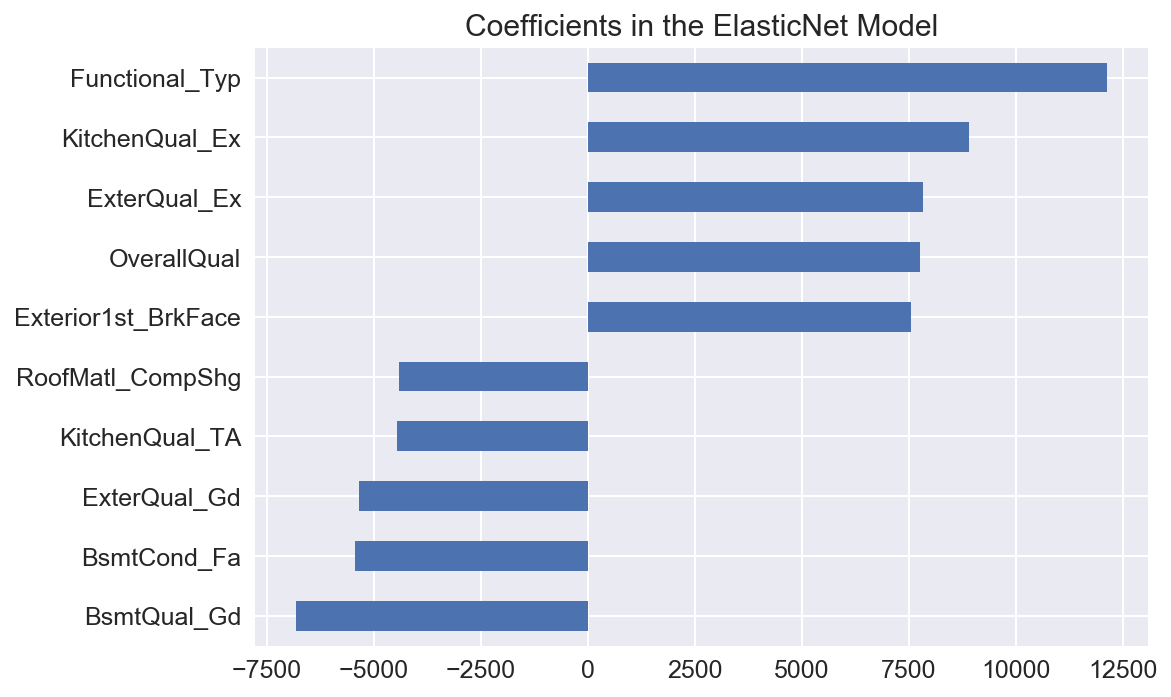

Functional_Typ         12139.841248
KitchenQual_Ex          8892.624828
ExterQual_Ex            7819.114983
OverallQual             7751.637843
Exterior1st_BrkFace     7551.939808
RoofMatl_CompShg       -4425.334206
KitchenQual_TA         -4458.237228
ExterQual_Gd           -5363.022951
BsmtCond_Fa            -5435.544904
BsmtQual_Gd            -6829.446539
dtype: float64


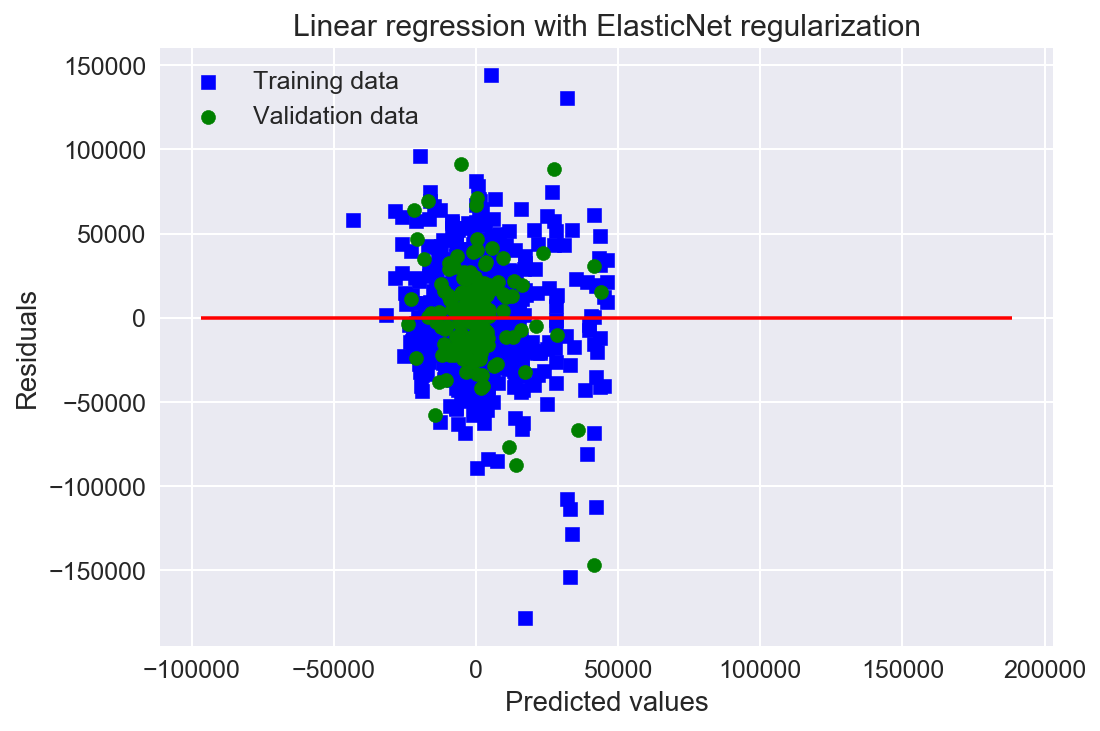

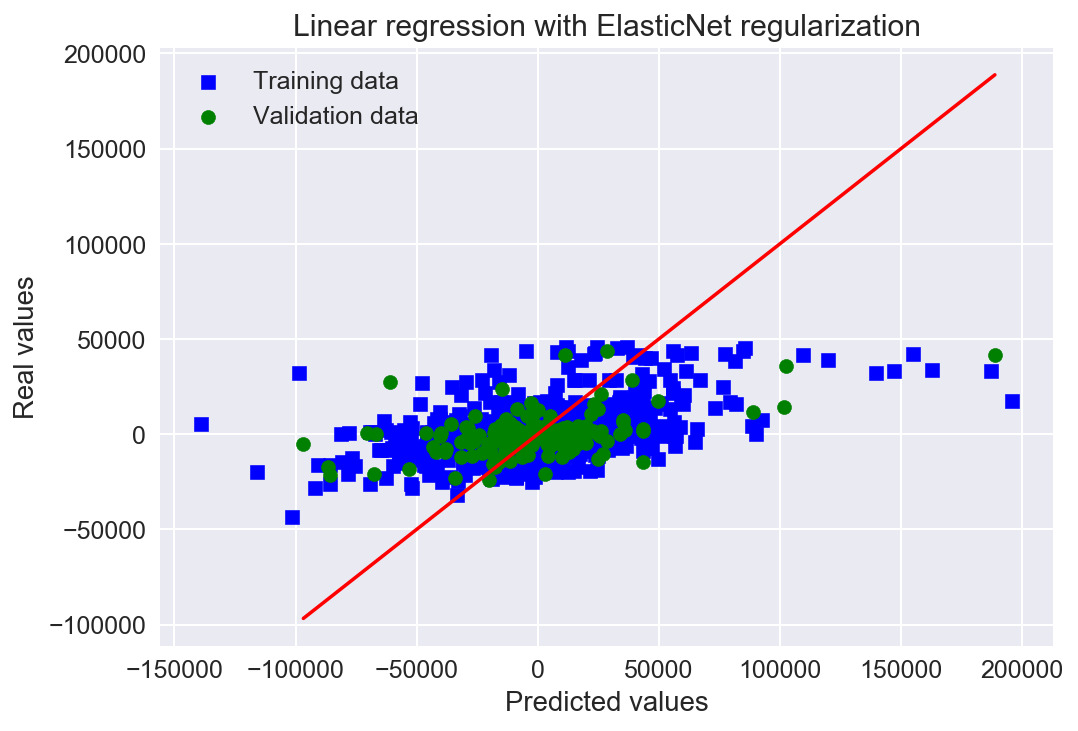

In [1994]:
final_model = elasticNet.fit(Xm_train, y_train)   
e_alpha = final_model.alpha_
ratio = final_model.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", e_alpha )

y_pred_train = final_model.predict(Xm_train)
y_pred_test = final_model.predict(Xm_test)
elasticNet_score = final_model.score(Xm_test, y_test)
elasticNet_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
elasticNet_coef = final_model.coef_
print "score:", elasticNet_score
print "RMSE:", elasticNet_rmse

# Plot important coefficients
coefs = pd.Series(elasticNet_coef, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(5),
                     coefs.sort_values().tail(5)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()
print imp_coefs.sort_values(ascending=False)

# Plot residuals
plt.scatter(y_pred_train, y_pred_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_test), xmax = max(y_test), color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_pred_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_pred_test, c = "green", marker = "o", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()